# OP2- XGBoost + Optuna
In this notebook, I tried to explore hyperparameters to improve the overfittings issues I am having with the model.

In [1]:
# Load libraries
import datetime

import pandas as pd
import numpy as np

import optuna
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

In [2]:
# Read data
df = pd.read_parquet("/kaggle/input/op2-train-v4/train_v4_20231120_1328.parquet")

In [3]:
# shuffle the data
df = df.sample(frac=1.0, random_state=42)

In [4]:
# Pre process data
df.head()

,cell_type,SMILES,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
350,T cells CD8+,Cn1cnc(-c2cc3nccc(Oc4ccc(NC(=S)NC(=O)Cc5ccccc5...,-0.148396,-0.339036,-0.482793,-0.474863,-0.115407,-0.899532,-0.190660,0.173307,...,3.886024,27.937873,-15.169586,-1.710256,160.096939,177.944412,342.401062,-7.801121,-2.440819,0.000234
377,T cells CD8+,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,-0.732587,-0.985970,-2.687669,-4.131173,-6.378904,-6.908058,-0.076590,-0.410899,...,3.886024,27.937873,-15.169586,-1.710256,160.096939,177.944412,342.401062,-7.801121,-2.440819,0.000234
163,T cells CD4+,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...,-0.177178,-0.124321,-0.088521,0.363095,-0.491432,0.100916,0.273153,0.276244,...,11.162104,13.415639,22.031963,-0.965761,-290.212463,-35.746544,9.742743,19.039822,125.504852,0.000234
609,Myeloid cells,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,-0.410827,0.055503,0.567753,0.943381,-0.218468,0.046093,-0.448680,0.055947,...,-23.501320,-15.499055,-4.531414,-8.835039,371.383972,-264.777924,-70.626099,-37.163532,28.948526,0.000234
132,NK cells,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,-1.026443,-0.024840,0.204772,-0.861985,-2.972540,0.466931,0.803999,0.007714,...,57.008103,-15.063747,-3.160472,0.046180,-76.865112,-96.008469,-15.021704,164.039307,-70.452560,0.000234


In [5]:
# One-hot encode 'cell_type'
encoder = OneHotEncoder(sparse_output=False)
cell_type_encoded = encoder.fit_transform(df[['cell_type']])
cell_type_df = pd.DataFrame(cell_type_encoded, columns=encoder.get_feature_names_out(['cell_type']))

# Drop the 'SMILES' and 'cell_type' columns
df.drop(['SMILES', 'cell_type'], axis=1, inplace=True)

# Concatenate one-hot encoded 'cell_type' to the DataFrame
df = pd.concat([cell_type_df, df], axis=1)

# Separate the features (X) and labels (y)
feature_cols = list(cell_type_df.columns) + [f'PC{i+1}' for i in range(31)]
X = df[feature_cols]
y = df.drop(feature_cols, axis=1)

# Split data into training and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [6]:
# Define custom metric (Mean Rowwise Root Mean Squared Error)
def mrrmse(preds, dtrain):
    labels = dtrain.get_label()
    n = labels.shape[1] if len(labels.shape) > 1 else 1  # Get the number of columns
    labels_reshaped = labels.reshape(-1, n)
    preds_reshaped = preds.reshape(-1, n)
    rowwise_errors = np.mean(np.square(labels_reshaped - preds_reshaped), axis=1)
    return 'MRRMSE', np.sqrt(np.mean(rowwise_errors))

In [7]:
# Ensure data is in float32 format
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

# Convert the dataset into the optimized data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [8]:
# Define number of boosting rounds
num_round = 100

# Optuna objective  
def objective(trial):
    
    params = {
        # Use shallower trees
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        
        # Adjust regularization terms
        'lambda': trial.suggest_uniform('lambda', 0.5, 5.0),
        'alpha': trial.suggest_uniform('alpha', 0.5, 5.0),
        
        # Feature subsampling
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
        
        # Increase this to make the algorithm more conservative
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        
        # Adjust the complexity control
        'gamma': trial.suggest_uniform('gamma', 0.1, 1.0),
        
        # Subsampling of the training instances
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.9),
    }

    # Train model
    bst = xgb.train(params, dtrain, num_round, evals=[(dval, 'eval')], early_stopping_rounds=10)
    
    # Get predictions
    preds = bst.predict(dval)
    
    # Evaluate MRRMSE
    metric = mrrmse(preds, dval)
    return metric[1]

# Create study   
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

# Get best hyperparameters
best_params = study.best_trial.params

[I 2023-11-20 20:01:07,691] A new study created in memory with name: no-name-9e954c79-fe0b-487e-9e96-bb23bdaf2b87
/tmp/ipykernel_20/4179395114.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'lambda': trial.suggest_uniform('lambda', 0.5, 5.0),
/tmp/ipykernel_20/4179395114.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'alpha': trial.suggest_uniform('alpha', 0.5, 5.0),
/tmp/ipykernel_20/4179395114.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
/tmp/ipykernel_20/4179395114.py:22

[0]	eval-rmse:2.43151
[1]	eval-rmse:2.40423
[2]	eval-rmse:2.38515
[3]	eval-rmse:2.37167
[4]	eval-rmse:2.36140
[5]	eval-rmse:2.35352
[6]	eval-rmse:2.34665
[7]	eval-rmse:2.34172
[8]	eval-rmse:2.33658
[9]	eval-rmse:2.33208
[10]	eval-rmse:2.32950
[11]	eval-rmse:2.32624
[12]	eval-rmse:2.32360
[13]	eval-rmse:2.32143
[14]	eval-rmse:2.32002
[15]	eval-rmse:2.31853
[16]	eval-rmse:2.31683
[17]	eval-rmse:2.31563
[18]	eval-rmse:2.31448
[19]	eval-rmse:2.31321
[20]	eval-rmse:2.31304
[21]	eval-rmse:2.31278
[22]	eval-rmse:2.31288
[23]	eval-rmse:2.31308
[24]	eval-rmse:2.31302
[25]	eval-rmse:2.31318
[26]	eval-rmse:2.31417
[27]	eval-rmse:2.31440
[28]	eval-rmse:2.31435
[29]	eval-rmse:2.31521
[30]	eval-rmse:2.31576
[31]	eval-rmse:2.31639


[I 2023-11-20 20:04:22,802] Trial 0 finished with value: 2.3163907527923584 and parameters: {'max_depth': 2, 'lambda': 1.8704967176708431, 'alpha': 1.334984390936963, 'colsample_bytree': 0.7796581081881565, 'min_child_weight': 6, 'gamma': 0.6769473352522721, 'subsample': 0.6275526277192137}. Best is trial 0 with value: 2.3163907527923584.


[0]	eval-rmse:2.43382
[1]	eval-rmse:2.40860
[2]	eval-rmse:2.39162
[3]	eval-rmse:2.38064
[4]	eval-rmse:2.37194
[5]	eval-rmse:2.36591
[6]	eval-rmse:2.36079
[7]	eval-rmse:2.35690
[8]	eval-rmse:2.35339
[9]	eval-rmse:2.34992
[10]	eval-rmse:2.34781
[11]	eval-rmse:2.34582
[12]	eval-rmse:2.34398
[13]	eval-rmse:2.34223
[14]	eval-rmse:2.34115
[15]	eval-rmse:2.34021
[16]	eval-rmse:2.33978
[17]	eval-rmse:2.33922
[18]	eval-rmse:2.33879
[19]	eval-rmse:2.33844
[20]	eval-rmse:2.33844
[21]	eval-rmse:2.33890
[22]	eval-rmse:2.33898
[23]	eval-rmse:2.33953
[24]	eval-rmse:2.33990
[25]	eval-rmse:2.34057
[26]	eval-rmse:2.34142
[27]	eval-rmse:2.34207
[28]	eval-rmse:2.34279


[I 2023-11-20 20:06:59,235] Trial 1 finished with value: 2.343641519546509 and parameters: {'max_depth': 2, 'lambda': 4.1606776870009385, 'alpha': 2.82273021660441, 'colsample_bytree': 0.5794321727836704, 'min_child_weight': 2, 'gamma': 0.2944523220847577, 'subsample': 0.8406389642616889}. Best is trial 0 with value: 2.3163907527923584.


[0]	eval-rmse:2.43484
[1]	eval-rmse:2.41017
[2]	eval-rmse:2.39333
[3]	eval-rmse:2.38259
[4]	eval-rmse:2.37454
[5]	eval-rmse:2.36874
[6]	eval-rmse:2.36463
[7]	eval-rmse:2.36182
[8]	eval-rmse:2.35832
[9]	eval-rmse:2.35594
[10]	eval-rmse:2.35503
[11]	eval-rmse:2.35350
[12]	eval-rmse:2.35159
[13]	eval-rmse:2.35052
[14]	eval-rmse:2.35068
[15]	eval-rmse:2.34987
[16]	eval-rmse:2.34912
[17]	eval-rmse:2.34801
[18]	eval-rmse:2.34763
[19]	eval-rmse:2.34693
[20]	eval-rmse:2.34688
[21]	eval-rmse:2.34672
[22]	eval-rmse:2.34672
[23]	eval-rmse:2.34664
[24]	eval-rmse:2.34686
[25]	eval-rmse:2.34700
[26]	eval-rmse:2.34742
[27]	eval-rmse:2.34759
[28]	eval-rmse:2.34766
[29]	eval-rmse:2.34804
[30]	eval-rmse:2.34840
[31]	eval-rmse:2.34872
[32]	eval-rmse:2.34965


[I 2023-11-20 20:10:06,045] Trial 2 finished with value: 2.3498475551605225 and parameters: {'max_depth': 2, 'lambda': 3.000219721250529, 'alpha': 2.143619861110976, 'colsample_bytree': 0.6470265107986041, 'min_child_weight': 3, 'gamma': 0.1269986051608842, 'subsample': 0.6323817529277235}. Best is trial 0 with value: 2.3163907527923584.


[0]	eval-rmse:2.44192
[1]	eval-rmse:2.42473
[2]	eval-rmse:2.41631
[3]	eval-rmse:2.41287
[4]	eval-rmse:2.41120
[5]	eval-rmse:2.41149
[6]	eval-rmse:2.41227
[7]	eval-rmse:2.41349
[8]	eval-rmse:2.41440
[9]	eval-rmse:2.41478
[10]	eval-rmse:2.41541
[11]	eval-rmse:2.41616
[12]	eval-rmse:2.41599
[13]	eval-rmse:2.41590
[14]	eval-rmse:2.41584


[I 2023-11-20 20:10:59,846] Trial 3 finished with value: 2.415839672088623 and parameters: {'max_depth': 1, 'lambda': 3.7332230248114553, 'alpha': 3.6660289441047684, 'colsample_bytree': 0.7880176093865738, 'min_child_weight': 6, 'gamma': 0.46190475352052474, 'subsample': 0.7787040540818008}. Best is trial 0 with value: 2.3163907527923584.


[0]	eval-rmse:2.43238
[1]	eval-rmse:2.40308
[2]	eval-rmse:2.38061
[3]	eval-rmse:2.36318
[4]	eval-rmse:2.34849
[5]	eval-rmse:2.33711
[6]	eval-rmse:2.32711
[7]	eval-rmse:2.31888
[8]	eval-rmse:2.31167
[9]	eval-rmse:2.30545
[10]	eval-rmse:2.30000
[11]	eval-rmse:2.29554
[12]	eval-rmse:2.29146
[13]	eval-rmse:2.28794
[14]	eval-rmse:2.28537
[15]	eval-rmse:2.28296
[16]	eval-rmse:2.28085
[17]	eval-rmse:2.27901
[18]	eval-rmse:2.27747
[19]	eval-rmse:2.27625
[20]	eval-rmse:2.27530
[21]	eval-rmse:2.27458
[22]	eval-rmse:2.27418
[23]	eval-rmse:2.27351
[24]	eval-rmse:2.27322
[25]	eval-rmse:2.27291
[26]	eval-rmse:2.27271
[27]	eval-rmse:2.27233
[28]	eval-rmse:2.27235
[29]	eval-rmse:2.27259
[30]	eval-rmse:2.27253
[31]	eval-rmse:2.27283
[32]	eval-rmse:2.27294
[33]	eval-rmse:2.27335
[34]	eval-rmse:2.27394
[35]	eval-rmse:2.27415
[36]	eval-rmse:2.27460
[37]	eval-rmse:2.27533


[I 2023-11-20 20:13:30,330] Trial 4 finished with value: 2.2753279209136963 and parameters: {'max_depth': 2, 'lambda': 4.901445027455212, 'alpha': 3.383077004440762, 'colsample_bytree': 0.23995969799832517, 'min_child_weight': 10, 'gamma': 0.1806130879412986, 'subsample': 0.7387835290241567}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.42774
[1]	eval-rmse:2.39683
[2]	eval-rmse:2.37476
[3]	eval-rmse:2.35832
[4]	eval-rmse:2.34476
[5]	eval-rmse:2.33521
[6]	eval-rmse:2.32683
[7]	eval-rmse:2.31964
[8]	eval-rmse:2.31334
[9]	eval-rmse:2.30787
[10]	eval-rmse:2.30406
[11]	eval-rmse:2.30029
[12]	eval-rmse:2.29697
[13]	eval-rmse:2.29435
[14]	eval-rmse:2.29290
[15]	eval-rmse:2.29118
[16]	eval-rmse:2.28994
[17]	eval-rmse:2.28878
[18]	eval-rmse:2.28795
[19]	eval-rmse:2.28737
[20]	eval-rmse:2.28680
[21]	eval-rmse:2.28661
[22]	eval-rmse:2.28684
[23]	eval-rmse:2.28677
[24]	eval-rmse:2.28696
[25]	eval-rmse:2.28737
[26]	eval-rmse:2.28787
[27]	eval-rmse:2.28828
[28]	eval-rmse:2.28894
[29]	eval-rmse:2.28983
[30]	eval-rmse:2.29045
[31]	eval-rmse:2.29116


[I 2023-11-20 20:16:16,584] Trial 5 finished with value: 2.291161298751831 and parameters: {'max_depth': 2, 'lambda': 2.4547962074117313, 'alpha': 3.0596846940855698, 'colsample_bytree': 0.5918803625088199, 'min_child_weight': 8, 'gamma': 0.4342764447213573, 'subsample': 0.7457713922706312}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.42553
[1]	eval-rmse:2.39249
[2]	eval-rmse:2.36778
[3]	eval-rmse:2.34966
[4]	eval-rmse:2.33489
[5]	eval-rmse:2.32456
[6]	eval-rmse:2.31583
[7]	eval-rmse:2.30902
[8]	eval-rmse:2.30341
[9]	eval-rmse:2.29913
[10]	eval-rmse:2.29619
[11]	eval-rmse:2.29270
[12]	eval-rmse:2.29009
[13]	eval-rmse:2.28831
[14]	eval-rmse:2.28809
[15]	eval-rmse:2.28760
[16]	eval-rmse:2.28712
[17]	eval-rmse:2.28726
[18]	eval-rmse:2.28747
[19]	eval-rmse:2.28833
[20]	eval-rmse:2.28897
[21]	eval-rmse:2.29007
[22]	eval-rmse:2.29121
[23]	eval-rmse:2.29215
[24]	eval-rmse:2.29295
[25]	eval-rmse:2.29424
[26]	eval-rmse:2.29555


[I 2023-11-20 20:18:52,873] Trial 6 finished with value: 2.2955470085144043 and parameters: {'max_depth': 3, 'lambda': 0.8673603237330345, 'alpha': 1.751731950403598, 'colsample_bytree': 0.24992266313257983, 'min_child_weight': 10, 'gamma': 0.8332241849795741, 'subsample': 0.6424093574982764}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.43133
[1]	eval-rmse:2.40564
[2]	eval-rmse:2.38983
[3]	eval-rmse:2.37915
[4]	eval-rmse:2.37012
[5]	eval-rmse:2.36381
[6]	eval-rmse:2.35879
[7]	eval-rmse:2.35470
[8]	eval-rmse:2.34985
[9]	eval-rmse:2.34535
[10]	eval-rmse:2.34175
[11]	eval-rmse:2.33874
[12]	eval-rmse:2.33490
[13]	eval-rmse:2.33225
[14]	eval-rmse:2.33020
[15]	eval-rmse:2.32781
[16]	eval-rmse:2.32620
[17]	eval-rmse:2.32409
[18]	eval-rmse:2.32238
[19]	eval-rmse:2.32089
[20]	eval-rmse:2.31991
[21]	eval-rmse:2.31903
[22]	eval-rmse:2.31854
[23]	eval-rmse:2.31791
[24]	eval-rmse:2.31731
[25]	eval-rmse:2.31695
[26]	eval-rmse:2.31655
[27]	eval-rmse:2.31616
[28]	eval-rmse:2.31594
[29]	eval-rmse:2.31593
[30]	eval-rmse:2.31601
[31]	eval-rmse:2.31617
[32]	eval-rmse:2.31611
[33]	eval-rmse:2.31626
[34]	eval-rmse:2.31663
[35]	eval-rmse:2.31643
[36]	eval-rmse:2.31659
[37]	eval-rmse:2.31724
[38]	eval-rmse:2.31749
[39]	eval-rmse:2.31779


[I 2023-11-20 20:23:08,866] Trial 7 finished with value: 2.3177905082702637 and parameters: {'max_depth': 2, 'lambda': 4.1555183023659845, 'alpha': 3.058846248851663, 'colsample_bytree': 0.8957252430112347, 'min_child_weight': 5, 'gamma': 0.38126170670621373, 'subsample': 0.7502570280021982}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.43631
[1]	eval-rmse:2.41069
[2]	eval-rmse:2.39177
[3]	eval-rmse:2.37697
[4]	eval-rmse:2.36500
[5]	eval-rmse:2.35564
[6]	eval-rmse:2.34772
[7]	eval-rmse:2.34069
[8]	eval-rmse:2.33477
[9]	eval-rmse:2.32962
[10]	eval-rmse:2.32512
[11]	eval-rmse:2.32109
[12]	eval-rmse:2.31748
[13]	eval-rmse:2.31402
[14]	eval-rmse:2.31150
[15]	eval-rmse:2.30912
[16]	eval-rmse:2.30691
[17]	eval-rmse:2.30475
[18]	eval-rmse:2.30330
[19]	eval-rmse:2.30181
[20]	eval-rmse:2.30054
[21]	eval-rmse:2.29955
[22]	eval-rmse:2.29871
[23]	eval-rmse:2.29795
[24]	eval-rmse:2.29718
[25]	eval-rmse:2.29679
[26]	eval-rmse:2.29626
[27]	eval-rmse:2.29575
[28]	eval-rmse:2.29560
[29]	eval-rmse:2.29542
[30]	eval-rmse:2.29526
[31]	eval-rmse:2.29511
[32]	eval-rmse:2.29518
[33]	eval-rmse:2.29541
[34]	eval-rmse:2.29534
[35]	eval-rmse:2.29553
[36]	eval-rmse:2.29566
[37]	eval-rmse:2.29599
[38]	eval-rmse:2.29639
[39]	eval-rmse:2.29666
[40]	eval-rmse:2.29687
[41]	eval-rmse:2.29741


[I 2023-11-20 20:25:42,643] Trial 8 finished with value: 2.297405481338501 and parameters: {'max_depth': 2, 'lambda': 2.829142039053087, 'alpha': 3.544181846274163, 'colsample_bytree': 0.16144336451190977, 'min_child_weight': 9, 'gamma': 0.17367684035705588, 'subsample': 0.8250296297908323}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.44623
[1]	eval-rmse:2.42971
[2]	eval-rmse:2.41929
[3]	eval-rmse:2.41231
[4]	eval-rmse:2.40736
[5]	eval-rmse:2.40368
[6]	eval-rmse:2.40075
[7]	eval-rmse:2.39829
[8]	eval-rmse:2.39637
[9]	eval-rmse:2.39442
[10]	eval-rmse:2.39300
[11]	eval-rmse:2.39156
[12]	eval-rmse:2.39013
[13]	eval-rmse:2.38875
[14]	eval-rmse:2.38741
[15]	eval-rmse:2.38616
[16]	eval-rmse:2.38495
[17]	eval-rmse:2.38366
[18]	eval-rmse:2.38238
[19]	eval-rmse:2.38105
[20]	eval-rmse:2.37985
[21]	eval-rmse:2.37857
[22]	eval-rmse:2.37734
[23]	eval-rmse:2.37607
[24]	eval-rmse:2.37494
[25]	eval-rmse:2.37372
[26]	eval-rmse:2.37247
[27]	eval-rmse:2.37138
[28]	eval-rmse:2.37039
[29]	eval-rmse:2.36945
[30]	eval-rmse:2.36835
[31]	eval-rmse:2.36733
[32]	eval-rmse:2.36638
[33]	eval-rmse:2.36541
[34]	eval-rmse:2.36454
[35]	eval-rmse:2.36363
[36]	eval-rmse:2.36284
[37]	eval-rmse:2.36207
[38]	eval-rmse:2.36123
[39]	eval-rmse:2.36057
[40]	eval-rmse:2.35968
[41]	eval-rmse:2.35902
[42]	eval-rmse:2.35841
[43]	eval-rmse:2.3576

[I 2023-11-20 20:30:17,655] Trial 9 finished with value: 2.3467772006988525 and parameters: {'max_depth': 1, 'lambda': 1.6820874166912683, 'alpha': 4.399308753136637, 'colsample_bytree': 0.22260430163899372, 'min_child_weight': 9, 'gamma': 0.4433671531288801, 'subsample': 0.8795257495962425}. Best is trial 4 with value: 2.2753279209136963.


[0]	eval-rmse:2.42321
[1]	eval-rmse:2.38705
[2]	eval-rmse:2.35941
[3]	eval-rmse:2.33896
[4]	eval-rmse:2.32226
[5]	eval-rmse:2.30961
[6]	eval-rmse:2.29953
[7]	eval-rmse:2.29149
[8]	eval-rmse:2.28496
[9]	eval-rmse:2.27990
[10]	eval-rmse:2.27580
[11]	eval-rmse:2.27238
[12]	eval-rmse:2.26927
[13]	eval-rmse:2.26706
[14]	eval-rmse:2.26602
[15]	eval-rmse:2.26504
[16]	eval-rmse:2.26453
[17]	eval-rmse:2.26426
[18]	eval-rmse:2.26436
[19]	eval-rmse:2.26493
[20]	eval-rmse:2.26526
[21]	eval-rmse:2.26618
[22]	eval-rmse:2.26741
[23]	eval-rmse:2.26805
[24]	eval-rmse:2.26940
[25]	eval-rmse:2.27065
[26]	eval-rmse:2.27171


[I 2023-11-20 20:33:13,000] Trial 10 finished with value: 2.272869110107422 and parameters: {'max_depth': 3, 'lambda': 4.6495898997868075, 'alpha': 0.6396641689520299, 'colsample_bytree': 0.3497771483619763, 'min_child_weight': 8, 'gamma': 0.631836953759197, 'subsample': 0.7087556862751552}. Best is trial 10 with value: 2.272869110107422.


[0]	eval-rmse:2.42286
[1]	eval-rmse:2.38654
[2]	eval-rmse:2.35855
[3]	eval-rmse:2.33758
[4]	eval-rmse:2.32076
[5]	eval-rmse:2.30831
[6]	eval-rmse:2.29806
[7]	eval-rmse:2.28993
[8]	eval-rmse:2.28305
[9]	eval-rmse:2.27754
[10]	eval-rmse:2.27361
[11]	eval-rmse:2.27014
[12]	eval-rmse:2.26729
[13]	eval-rmse:2.26529
[14]	eval-rmse:2.26427
[15]	eval-rmse:2.26314
[16]	eval-rmse:2.26249
[17]	eval-rmse:2.26215
[18]	eval-rmse:2.26204
[19]	eval-rmse:2.26257
[20]	eval-rmse:2.26290
[21]	eval-rmse:2.26360
[22]	eval-rmse:2.26457
[23]	eval-rmse:2.26527
[24]	eval-rmse:2.26662
[25]	eval-rmse:2.26785
[26]	eval-rmse:2.26904
[27]	eval-rmse:2.27062
[28]	eval-rmse:2.27196


[I 2023-11-20 20:36:18,554] Trial 11 finished with value: 2.271958589553833 and parameters: {'max_depth': 3, 'lambda': 4.96823326059943, 'alpha': 0.603051465812972, 'colsample_bytree': 0.3633066061036302, 'min_child_weight': 8, 'gamma': 0.6342718670024647, 'subsample': 0.6935257749282517}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.42197
[1]	eval-rmse:2.38521
[2]	eval-rmse:2.35712
[3]	eval-rmse:2.33632
[4]	eval-rmse:2.31959
[5]	eval-rmse:2.30723
[6]	eval-rmse:2.29699
[7]	eval-rmse:2.28896
[8]	eval-rmse:2.28212
[9]	eval-rmse:2.27691
[10]	eval-rmse:2.27336
[11]	eval-rmse:2.26986
[12]	eval-rmse:2.26693
[13]	eval-rmse:2.26487
[14]	eval-rmse:2.26399
[15]	eval-rmse:2.26311
[16]	eval-rmse:2.26240
[17]	eval-rmse:2.26217
[18]	eval-rmse:2.26216
[19]	eval-rmse:2.26262
[20]	eval-rmse:2.26306
[21]	eval-rmse:2.26418
[22]	eval-rmse:2.26535
[23]	eval-rmse:2.26636
[24]	eval-rmse:2.26759
[25]	eval-rmse:2.26878
[26]	eval-rmse:2.27006
[27]	eval-rmse:2.27157
[28]	eval-rmse:2.27310


[I 2023-11-20 20:39:27,466] Trial 12 finished with value: 2.273103713989258 and parameters: {'max_depth': 3, 'lambda': 4.787545544192479, 'alpha': 0.6178505509896826, 'colsample_bytree': 0.38967129613247875, 'min_child_weight': 8, 'gamma': 0.6350403595114348, 'subsample': 0.6925091781845354}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.42323
[1]	eval-rmse:2.38680
[2]	eval-rmse:2.35914
[3]	eval-rmse:2.33851
[4]	eval-rmse:2.32153
[5]	eval-rmse:2.30936
[6]	eval-rmse:2.29915
[7]	eval-rmse:2.29124
[8]	eval-rmse:2.28475
[9]	eval-rmse:2.27957
[10]	eval-rmse:2.27570
[11]	eval-rmse:2.27219
[12]	eval-rmse:2.26933
[13]	eval-rmse:2.26730
[14]	eval-rmse:2.26646
[15]	eval-rmse:2.26557
[16]	eval-rmse:2.26477
[17]	eval-rmse:2.26438
[18]	eval-rmse:2.26443
[19]	eval-rmse:2.26480
[20]	eval-rmse:2.26542
[21]	eval-rmse:2.26635
[22]	eval-rmse:2.26729
[23]	eval-rmse:2.26837
[24]	eval-rmse:2.26954
[25]	eval-rmse:2.27075
[26]	eval-rmse:2.27227
[27]	eval-rmse:2.27358


[I 2023-11-20 20:42:36,218] Trial 13 finished with value: 2.2735812664031982 and parameters: {'max_depth': 3, 'lambda': 4.96291867908315, 'alpha': 0.5594154138268704, 'colsample_bytree': 0.4037203346510925, 'min_child_weight': 7, 'gamma': 0.9689821771901612, 'subsample': 0.6795237748104385}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.42342
[1]	eval-rmse:2.38820
[2]	eval-rmse:2.36232
[3]	eval-rmse:2.34330
[4]	eval-rmse:2.32833
[5]	eval-rmse:2.31801
[6]	eval-rmse:2.30987
[7]	eval-rmse:2.30405
[8]	eval-rmse:2.29921
[9]	eval-rmse:2.29578
[10]	eval-rmse:2.29358
[11]	eval-rmse:2.29138
[12]	eval-rmse:2.28947
[13]	eval-rmse:2.28842
[14]	eval-rmse:2.28879
[15]	eval-rmse:2.28850
[16]	eval-rmse:2.28852
[17]	eval-rmse:2.28866
[18]	eval-rmse:2.28897
[19]	eval-rmse:2.28992
[20]	eval-rmse:2.29083
[21]	eval-rmse:2.29206
[22]	eval-rmse:2.29326


[I 2023-11-20 20:45:11,543] Trial 14 finished with value: 2.2942683696746826 and parameters: {'max_depth': 3, 'lambda': 3.5871369439593646, 'alpha': 1.1852502724139091, 'colsample_bytree': 0.37201619914081063, 'min_child_weight': 4, 'gamma': 0.6351030725321198, 'subsample': 0.694793796410854}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.42284
[1]	eval-rmse:2.38687
[2]	eval-rmse:2.36013
[3]	eval-rmse:2.34014
[4]	eval-rmse:2.32419
[5]	eval-rmse:2.31196
[6]	eval-rmse:2.30256
[7]	eval-rmse:2.29510
[8]	eval-rmse:2.28881
[9]	eval-rmse:2.28373
[10]	eval-rmse:2.27999
[11]	eval-rmse:2.27715
[12]	eval-rmse:2.27435
[13]	eval-rmse:2.27253
[14]	eval-rmse:2.27153
[15]	eval-rmse:2.27065
[16]	eval-rmse:2.27013
[17]	eval-rmse:2.27011
[18]	eval-rmse:2.27000
[19]	eval-rmse:2.27024
[20]	eval-rmse:2.27076
[21]	eval-rmse:2.27154
[22]	eval-rmse:2.27242
[23]	eval-rmse:2.27335
[24]	eval-rmse:2.27461
[25]	eval-rmse:2.27595
[26]	eval-rmse:2.27777
[27]	eval-rmse:2.27900


[I 2023-11-20 20:48:26,481] Trial 15 finished with value: 2.2803523540496826 and parameters: {'max_depth': 3, 'lambda': 4.432313590315172, 'alpha': 0.5063499659509332, 'colsample_bytree': 0.45152971602514647, 'min_child_weight': 7, 'gamma': 0.5583439429248881, 'subsample': 0.6020700785462043}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.42302
[1]	eval-rmse:2.38720
[2]	eval-rmse:2.35971
[3]	eval-rmse:2.33958
[4]	eval-rmse:2.32312
[5]	eval-rmse:2.31096
[6]	eval-rmse:2.30102
[7]	eval-rmse:2.29313
[8]	eval-rmse:2.28680
[9]	eval-rmse:2.28157
[10]	eval-rmse:2.27762
[11]	eval-rmse:2.27412
[12]	eval-rmse:2.27113
[13]	eval-rmse:2.26907
[14]	eval-rmse:2.26806
[15]	eval-rmse:2.26737
[16]	eval-rmse:2.26690
[17]	eval-rmse:2.26643
[18]	eval-rmse:2.26629
[19]	eval-rmse:2.26679
[20]	eval-rmse:2.26702
[21]	eval-rmse:2.26766
[22]	eval-rmse:2.26878
[23]	eval-rmse:2.26957
[24]	eval-rmse:2.27054
[25]	eval-rmse:2.27176
[26]	eval-rmse:2.27286
[27]	eval-rmse:2.27392


[I 2023-11-20 20:51:26,750] Trial 16 finished with value: 2.2750799655914307 and parameters: {'max_depth': 3, 'lambda': 3.636093950149716, 'alpha': 2.05355747639737, 'colsample_bytree': 0.3268471822116355, 'min_child_weight': 8, 'gamma': 0.7650746344379462, 'subsample': 0.7114888891589474}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.43511
[1]	eval-rmse:2.40751
[2]	eval-rmse:2.38683
[3]	eval-rmse:2.37109
[4]	eval-rmse:2.35779
[5]	eval-rmse:2.34705
[6]	eval-rmse:2.33844
[7]	eval-rmse:2.33144
[8]	eval-rmse:2.32559
[9]	eval-rmse:2.32065
[10]	eval-rmse:2.31648
[11]	eval-rmse:2.31285
[12]	eval-rmse:2.30958
[13]	eval-rmse:2.30707
[14]	eval-rmse:2.30554
[15]	eval-rmse:2.30382
[16]	eval-rmse:2.30242
[17]	eval-rmse:2.30095
[18]	eval-rmse:2.30004
[19]	eval-rmse:2.29976
[20]	eval-rmse:2.29921
[21]	eval-rmse:2.29889
[22]	eval-rmse:2.29876
[23]	eval-rmse:2.29884
[24]	eval-rmse:2.29891
[25]	eval-rmse:2.29947
[26]	eval-rmse:2.29993
[27]	eval-rmse:2.30025
[28]	eval-rmse:2.30062
[29]	eval-rmse:2.30138
[30]	eval-rmse:2.30203
[31]	eval-rmse:2.30264
[32]	eval-rmse:2.30346


[I 2023-11-20 20:54:12,852] Trial 17 finished with value: 2.3034565448760986 and parameters: {'max_depth': 3, 'lambda': 4.362431982948819, 'alpha': 1.255367632435002, 'colsample_bytree': 0.12565663174167485, 'min_child_weight': 7, 'gamma': 0.5692808749055025, 'subsample': 0.6681253265079047}. Best is trial 11 with value: 2.271958589553833.


[0]	eval-rmse:2.41932
[1]	eval-rmse:2.38072
[2]	eval-rmse:2.35174
[3]	eval-rmse:2.33020
[4]	eval-rmse:2.31306
[5]	eval-rmse:2.30019
[6]	eval-rmse:2.28967
[7]	eval-rmse:2.28138
[8]	eval-rmse:2.27442
[9]	eval-rmse:2.26884
[10]	eval-rmse:2.26448
[11]	eval-rmse:2.26105
[12]	eval-rmse:2.25782
[13]	eval-rmse:2.25560
[14]	eval-rmse:2.25445
[15]	eval-rmse:2.25320
[16]	eval-rmse:2.25261
[17]	eval-rmse:2.25235
[18]	eval-rmse:2.25251
[19]	eval-rmse:2.25288
[20]	eval-rmse:2.25361
[21]	eval-rmse:2.25410
[22]	eval-rmse:2.25517
[23]	eval-rmse:2.25608
[24]	eval-rmse:2.25725
[25]	eval-rmse:2.25860
[26]	eval-rmse:2.26013


[I 2023-11-20 20:57:32,629] Trial 18 finished with value: 2.261544704437256 and parameters: {'max_depth': 3, 'lambda': 4.614152844708913, 'alpha': 2.444553817359008, 'colsample_bytree': 0.48741326869139473, 'min_child_weight': 9, 'gamma': 0.7641808175368991, 'subsample': 0.7202786505722429}. Best is trial 18 with value: 2.261544704437256.


[0]	eval-rmse:2.44086
[1]	eval-rmse:2.41952
[2]	eval-rmse:2.40537
[3]	eval-rmse:2.39591
[4]	eval-rmse:2.38833
[5]	eval-rmse:2.38311
[6]	eval-rmse:2.37853
[7]	eval-rmse:2.37530
[8]	eval-rmse:2.37228
[9]	eval-rmse:2.36996
[10]	eval-rmse:2.36816
[11]	eval-rmse:2.36600
[12]	eval-rmse:2.36413
[13]	eval-rmse:2.36242
[14]	eval-rmse:2.36117
[15]	eval-rmse:2.35966
[16]	eval-rmse:2.35813
[17]	eval-rmse:2.35683
[18]	eval-rmse:2.35545
[19]	eval-rmse:2.35390
[20]	eval-rmse:2.35263
[21]	eval-rmse:2.35164
[22]	eval-rmse:2.35035
[23]	eval-rmse:2.34934
[24]	eval-rmse:2.34831
[25]	eval-rmse:2.34712
[26]	eval-rmse:2.34622
[27]	eval-rmse:2.34536
[28]	eval-rmse:2.34430
[29]	eval-rmse:2.34343
[30]	eval-rmse:2.34258
[31]	eval-rmse:2.34161
[32]	eval-rmse:2.34086
[33]	eval-rmse:2.34008
[34]	eval-rmse:2.33948
[35]	eval-rmse:2.33873
[36]	eval-rmse:2.33786
[37]	eval-rmse:2.33751
[38]	eval-rmse:2.33695
[39]	eval-rmse:2.33641
[40]	eval-rmse:2.33617
[41]	eval-rmse:2.33582
[42]	eval-rmse:2.33561
[43]	eval-rmse:2.3350

[I 2023-11-20 21:01:50,872] Trial 19 finished with value: 2.3327722549438477 and parameters: {'max_depth': 1, 'lambda': 3.983903533272284, 'alpha': 2.3528007887910043, 'colsample_bytree': 0.48161797727163747, 'min_child_weight': 9, 'gamma': 0.7726587692678528, 'subsample': 0.6651376228119312}. Best is trial 18 with value: 2.261544704437256.


[0]	eval-rmse:2.41736
[1]	eval-rmse:2.37754
[2]	eval-rmse:2.34796
[3]	eval-rmse:2.32521
[4]	eval-rmse:2.30790
[5]	eval-rmse:2.29529
[6]	eval-rmse:2.28431
[7]	eval-rmse:2.27589
[8]	eval-rmse:2.26873
[9]	eval-rmse:2.26326
[10]	eval-rmse:2.25942
[11]	eval-rmse:2.25603
[12]	eval-rmse:2.25329
[13]	eval-rmse:2.25101
[14]	eval-rmse:2.25007
[15]	eval-rmse:2.24901
[16]	eval-rmse:2.24882
[17]	eval-rmse:2.24857
[18]	eval-rmse:2.24866
[19]	eval-rmse:2.24937
[20]	eval-rmse:2.25028
[21]	eval-rmse:2.25115
[22]	eval-rmse:2.25254
[23]	eval-rmse:2.25386
[24]	eval-rmse:2.25545
[25]	eval-rmse:2.25703
[26]	eval-rmse:2.25860
[27]	eval-rmse:2.26010


[I 2023-11-20 21:05:16,027] Trial 20 finished with value: 2.2600975036621094 and parameters: {'max_depth': 3, 'lambda': 4.475040482331893, 'alpha': 2.570362617180294, 'colsample_bytree': 0.5188195862248711, 'min_child_weight': 10, 'gamma': 0.8940875161751788, 'subsample': 0.7814829902817242}. Best is trial 20 with value: 2.2600975036621094.


[0]	eval-rmse:2.41803
[1]	eval-rmse:2.37845
[2]	eval-rmse:2.34886
[3]	eval-rmse:2.32593
[4]	eval-rmse:2.30835
[5]	eval-rmse:2.29525
[6]	eval-rmse:2.28413
[7]	eval-rmse:2.27560
[8]	eval-rmse:2.26804
[9]	eval-rmse:2.26214
[10]	eval-rmse:2.25807
[11]	eval-rmse:2.25470
[12]	eval-rmse:2.25187
[13]	eval-rmse:2.24976
[14]	eval-rmse:2.24874
[15]	eval-rmse:2.24767
[16]	eval-rmse:2.24739
[17]	eval-rmse:2.24716
[18]	eval-rmse:2.24729
[19]	eval-rmse:2.24769
[20]	eval-rmse:2.24850
[21]	eval-rmse:2.24920
[22]	eval-rmse:2.25039
[23]	eval-rmse:2.25145
[24]	eval-rmse:2.25299
[25]	eval-rmse:2.25456
[26]	eval-rmse:2.25606
[27]	eval-rmse:2.25757


[I 2023-11-20 21:08:40,237] Trial 21 finished with value: 2.2575714588165283 and parameters: {'max_depth': 3, 'lambda': 4.982477390726393, 'alpha': 2.631657314825429, 'colsample_bytree': 0.5135673553357182, 'min_child_weight': 10, 'gamma': 0.9029126362128643, 'subsample': 0.7818305112233835}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41704
[1]	eval-rmse:2.37670
[2]	eval-rmse:2.34708
[3]	eval-rmse:2.32465
[4]	eval-rmse:2.30731
[5]	eval-rmse:2.29461
[6]	eval-rmse:2.28395
[7]	eval-rmse:2.27556
[8]	eval-rmse:2.26846
[9]	eval-rmse:2.26258
[10]	eval-rmse:2.25827
[11]	eval-rmse:2.25471
[12]	eval-rmse:2.25225
[13]	eval-rmse:2.25038
[14]	eval-rmse:2.24968
[15]	eval-rmse:2.24902
[16]	eval-rmse:2.24870
[17]	eval-rmse:2.24865
[18]	eval-rmse:2.24913
[19]	eval-rmse:2.25018
[20]	eval-rmse:2.25117
[21]	eval-rmse:2.25219
[22]	eval-rmse:2.25335
[23]	eval-rmse:2.25456
[24]	eval-rmse:2.25618
[25]	eval-rmse:2.25786
[26]	eval-rmse:2.25958


[I 2023-11-20 21:12:08,201] Trial 22 finished with value: 2.2609410285949707 and parameters: {'max_depth': 3, 'lambda': 4.481156647177177, 'alpha': 2.5391897786725575, 'colsample_bytree': 0.5317324455253448, 'min_child_weight': 10, 'gamma': 0.9935891142311954, 'subsample': 0.8002744273242121}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41650
[1]	eval-rmse:2.37625
[2]	eval-rmse:2.34677
[3]	eval-rmse:2.32431
[4]	eval-rmse:2.30678
[5]	eval-rmse:2.29389
[6]	eval-rmse:2.28308
[7]	eval-rmse:2.27480
[8]	eval-rmse:2.26774
[9]	eval-rmse:2.26204
[10]	eval-rmse:2.25815
[11]	eval-rmse:2.25465
[12]	eval-rmse:2.25182
[13]	eval-rmse:2.24991
[14]	eval-rmse:2.24909
[15]	eval-rmse:2.24829
[16]	eval-rmse:2.24810
[17]	eval-rmse:2.24813
[18]	eval-rmse:2.24817
[19]	eval-rmse:2.24921
[20]	eval-rmse:2.25022
[21]	eval-rmse:2.25117
[22]	eval-rmse:2.25251
[23]	eval-rmse:2.25368
[24]	eval-rmse:2.25509
[25]	eval-rmse:2.25691


[I 2023-11-20 21:15:31,017] Trial 23 finished with value: 2.258434534072876 and parameters: {'max_depth': 3, 'lambda': 4.4170869882157655, 'alpha': 2.6812270522222383, 'colsample_bytree': 0.5420747445616667, 'min_child_weight': 10, 'gamma': 0.9996934959124185, 'subsample': 0.7885767170501455}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41635
[1]	eval-rmse:2.37618
[2]	eval-rmse:2.34708
[3]	eval-rmse:2.32450
[4]	eval-rmse:2.30744
[5]	eval-rmse:2.29495
[6]	eval-rmse:2.28399
[7]	eval-rmse:2.27576
[8]	eval-rmse:2.26876
[9]	eval-rmse:2.26318
[10]	eval-rmse:2.25952
[11]	eval-rmse:2.25642
[12]	eval-rmse:2.25401
[13]	eval-rmse:2.25213
[14]	eval-rmse:2.25151
[15]	eval-rmse:2.25080
[16]	eval-rmse:2.25072
[17]	eval-rmse:2.25100
[18]	eval-rmse:2.25124
[19]	eval-rmse:2.25226
[20]	eval-rmse:2.25321
[21]	eval-rmse:2.25428
[22]	eval-rmse:2.25558
[23]	eval-rmse:2.25714
[24]	eval-rmse:2.25847
[25]	eval-rmse:2.26021
[26]	eval-rmse:2.26204


[I 2023-11-20 21:18:49,567] Trial 24 finished with value: 2.2620413303375244 and parameters: {'max_depth': 3, 'lambda': 3.959877831320665, 'alpha': 2.7767974395588664, 'colsample_bytree': 0.5528243860596356, 'min_child_weight': 10, 'gamma': 0.9313417576744863, 'subsample': 0.7820413968009212}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41584
[1]	eval-rmse:2.37521
[2]	eval-rmse:2.34573
[3]	eval-rmse:2.32330
[4]	eval-rmse:2.30562
[5]	eval-rmse:2.29297
[6]	eval-rmse:2.28250
[7]	eval-rmse:2.27471
[8]	eval-rmse:2.26808
[9]	eval-rmse:2.26247
[10]	eval-rmse:2.25862
[11]	eval-rmse:2.25509
[12]	eval-rmse:2.25270
[13]	eval-rmse:2.25082
[14]	eval-rmse:2.25014
[15]	eval-rmse:2.24970
[16]	eval-rmse:2.24963
[17]	eval-rmse:2.25013
[18]	eval-rmse:2.25057
[19]	eval-rmse:2.25106
[20]	eval-rmse:2.25219
[21]	eval-rmse:2.25345
[22]	eval-rmse:2.25510
[23]	eval-rmse:2.25640
[24]	eval-rmse:2.25786
[25]	eval-rmse:2.25974
[26]	eval-rmse:2.26153


[I 2023-11-20 21:22:17,338] Trial 25 finished with value: 2.2615268230438232 and parameters: {'max_depth': 3, 'lambda': 4.396465265041974, 'alpha': 2.0026142381059424, 'colsample_bytree': 0.6187769401142795, 'min_child_weight': 10, 'gamma': 0.9099105559728631, 'subsample': 0.7705965965141753}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41760
[1]	eval-rmse:2.37881
[2]	eval-rmse:2.34989
[3]	eval-rmse:2.32851
[4]	eval-rmse:2.31199
[5]	eval-rmse:2.29981
[6]	eval-rmse:2.28941
[7]	eval-rmse:2.28148
[8]	eval-rmse:2.27523
[9]	eval-rmse:2.26978
[10]	eval-rmse:2.26574
[11]	eval-rmse:2.26236
[12]	eval-rmse:2.25980
[13]	eval-rmse:2.25824
[14]	eval-rmse:2.25729
[15]	eval-rmse:2.25678
[16]	eval-rmse:2.25652
[17]	eval-rmse:2.25654
[18]	eval-rmse:2.25689
[19]	eval-rmse:2.25743
[20]	eval-rmse:2.25845
[21]	eval-rmse:2.25911
[22]	eval-rmse:2.26027
[23]	eval-rmse:2.26151
[24]	eval-rmse:2.26280
[25]	eval-rmse:2.26429


[I 2023-11-20 21:25:21,597] Trial 26 finished with value: 2.2659482955932617 and parameters: {'max_depth': 3, 'lambda': 3.3887145469524595, 'alpha': 2.5913384895008567, 'colsample_bytree': 0.4502986949853734, 'min_child_weight': 9, 'gamma': 0.9192580537757327, 'subsample': 0.8060594189070578}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.42473
[1]	eval-rmse:2.38975
[2]	eval-rmse:2.36437
[3]	eval-rmse:2.34512
[4]	eval-rmse:2.32954
[5]	eval-rmse:2.31769
[6]	eval-rmse:2.30778
[7]	eval-rmse:2.29989
[8]	eval-rmse:2.29326
[9]	eval-rmse:2.28745
[10]	eval-rmse:2.28313
[11]	eval-rmse:2.27942
[12]	eval-rmse:2.27628
[13]	eval-rmse:2.27351
[14]	eval-rmse:2.27161
[15]	eval-rmse:2.26989
[16]	eval-rmse:2.26859
[17]	eval-rmse:2.26736
[18]	eval-rmse:2.26651
[19]	eval-rmse:2.26592
[20]	eval-rmse:2.26556
[21]	eval-rmse:2.26527
[22]	eval-rmse:2.26545
[23]	eval-rmse:2.26570
[24]	eval-rmse:2.26619
[25]	eval-rmse:2.26654
[26]	eval-rmse:2.26723
[27]	eval-rmse:2.26777
[28]	eval-rmse:2.26848
[29]	eval-rmse:2.26926
[30]	eval-rmse:2.26992
[31]	eval-rmse:2.27067


[I 2023-11-20 21:28:02,137] Trial 27 finished with value: 2.2706689834594727 and parameters: {'max_depth': 2, 'lambda': 4.141130177196228, 'alpha': 3.199239956992722, 'colsample_bytree': 0.5303061863832348, 'min_child_weight': 10, 'gamma': 0.8660279365054595, 'subsample': 0.7679828532316576}. Best is trial 21 with value: 2.2575714588165283.


[0]	eval-rmse:2.41560
[1]	eval-rmse:2.37475
[2]	eval-rmse:2.34476
[3]	eval-rmse:2.32212
[4]	eval-rmse:2.30445
[5]	eval-rmse:2.29132
[6]	eval-rmse:2.28049
[7]	eval-rmse:2.27201
[8]	eval-rmse:2.26516
[9]	eval-rmse:2.25924
[10]	eval-rmse:2.25505
[11]	eval-rmse:2.25143
[12]	eval-rmse:2.24884
[13]	eval-rmse:2.24699
[14]	eval-rmse:2.24598
[15]	eval-rmse:2.24520
[16]	eval-rmse:2.24482
[17]	eval-rmse:2.24443
[18]	eval-rmse:2.24460
[19]	eval-rmse:2.24533
[20]	eval-rmse:2.24620
[21]	eval-rmse:2.24734
[22]	eval-rmse:2.24874
[23]	eval-rmse:2.24997
[24]	eval-rmse:2.25128
[25]	eval-rmse:2.25300
[26]	eval-rmse:2.25447
[27]	eval-rmse:2.25586


[I 2023-11-20 21:31:41,762] Trial 28 finished with value: 2.255859613418579 and parameters: {'max_depth': 3, 'lambda': 4.665809616059942, 'alpha': 3.8876480440151777, 'colsample_bytree': 0.64695027675293, 'min_child_weight': 9, 'gamma': 0.982997251747409, 'subsample': 0.7985569226889759}. Best is trial 28 with value: 2.255859613418579.


[0]	eval-rmse:2.43082
[1]	eval-rmse:2.40283
[2]	eval-rmse:2.38310
[3]	eval-rmse:2.36904
[4]	eval-rmse:2.35750
[5]	eval-rmse:2.34896
[6]	eval-rmse:2.34102
[7]	eval-rmse:2.33413
[8]	eval-rmse:2.32819
[9]	eval-rmse:2.32216
[10]	eval-rmse:2.31772
[11]	eval-rmse:2.31323
[12]	eval-rmse:2.30933
[13]	eval-rmse:2.30574
[14]	eval-rmse:2.30289
[15]	eval-rmse:2.30042
[16]	eval-rmse:2.29826
[17]	eval-rmse:2.29640
[18]	eval-rmse:2.29478
[19]	eval-rmse:2.29354
[20]	eval-rmse:2.29249
[21]	eval-rmse:2.29181
[22]	eval-rmse:2.29146
[23]	eval-rmse:2.29098
[24]	eval-rmse:2.29090
[25]	eval-rmse:2.29104
[26]	eval-rmse:2.29120
[27]	eval-rmse:2.29131
[28]	eval-rmse:2.29152
[29]	eval-rmse:2.29207
[30]	eval-rmse:2.29255
[31]	eval-rmse:2.29300
[32]	eval-rmse:2.29347
[33]	eval-rmse:2.29402
[34]	eval-rmse:2.29456


[I 2023-11-20 21:34:55,254] Trial 29 finished with value: 2.2945637702941895 and parameters: {'max_depth': 2, 'lambda': 4.986503582327534, 'alpha': 3.9774901121733564, 'colsample_bytree': 0.6671352767267626, 'min_child_weight': 6, 'gamma': 0.9985279358598561, 'subsample': 0.8468806202179706}. Best is trial 28 with value: 2.255859613418579.


[0]	eval-rmse:2.41474
[1]	eval-rmse:2.37351
[2]	eval-rmse:2.34319
[3]	eval-rmse:2.32055
[4]	eval-rmse:2.30313
[5]	eval-rmse:2.28986
[6]	eval-rmse:2.27894
[7]	eval-rmse:2.27068
[8]	eval-rmse:2.26348
[9]	eval-rmse:2.25719
[10]	eval-rmse:2.25293
[11]	eval-rmse:2.24963
[12]	eval-rmse:2.24700
[13]	eval-rmse:2.24481
[14]	eval-rmse:2.24391
[15]	eval-rmse:2.24283
[16]	eval-rmse:2.24250
[17]	eval-rmse:2.24206
[18]	eval-rmse:2.24241
[19]	eval-rmse:2.24301
[20]	eval-rmse:2.24390
[21]	eval-rmse:2.24498
[22]	eval-rmse:2.24628
[23]	eval-rmse:2.24742
[24]	eval-rmse:2.24873
[25]	eval-rmse:2.25037
[26]	eval-rmse:2.25185
[27]	eval-rmse:2.25304


[I 2023-11-20 21:38:42,977] Trial 30 finished with value: 2.253044605255127 and parameters: {'max_depth': 3, 'lambda': 4.664573904083198, 'alpha': 4.928469190849132, 'colsample_bytree': 0.6940275118245642, 'min_child_weight': 9, 'gamma': 0.8128314195552311, 'subsample': 0.8119326389263868}. Best is trial 30 with value: 2.253044605255127.


[0]	eval-rmse:2.41455
[1]	eval-rmse:2.37332
[2]	eval-rmse:2.34306
[3]	eval-rmse:2.32031
[4]	eval-rmse:2.30289
[5]	eval-rmse:2.28949
[6]	eval-rmse:2.27888
[7]	eval-rmse:2.27052
[8]	eval-rmse:2.26344
[9]	eval-rmse:2.25761
[10]	eval-rmse:2.25329
[11]	eval-rmse:2.24979
[12]	eval-rmse:2.24721
[13]	eval-rmse:2.24521
[14]	eval-rmse:2.24400
[15]	eval-rmse:2.24314
[16]	eval-rmse:2.24292
[17]	eval-rmse:2.24251
[18]	eval-rmse:2.24278
[19]	eval-rmse:2.24322
[20]	eval-rmse:2.24423
[21]	eval-rmse:2.24520
[22]	eval-rmse:2.24643
[23]	eval-rmse:2.24776
[24]	eval-rmse:2.24918
[25]	eval-rmse:2.25081
[26]	eval-rmse:2.25225
[27]	eval-rmse:2.25374


[I 2023-11-20 21:42:33,985] Trial 31 finished with value: 2.2537426948547363 and parameters: {'max_depth': 3, 'lambda': 4.651219954961281, 'alpha': 4.933579503585202, 'colsample_bytree': 0.7033300475193309, 'min_child_weight': 9, 'gamma': 0.950445668604231, 'subsample': 0.8022208343362486}. Best is trial 30 with value: 2.253044605255127.


[0]	eval-rmse:2.41431
[1]	eval-rmse:2.37274
[2]	eval-rmse:2.34238
[3]	eval-rmse:2.31985
[4]	eval-rmse:2.30248
[5]	eval-rmse:2.28892
[6]	eval-rmse:2.27793
[7]	eval-rmse:2.26912
[8]	eval-rmse:2.26212
[9]	eval-rmse:2.25618
[10]	eval-rmse:2.25191
[11]	eval-rmse:2.24847
[12]	eval-rmse:2.24605
[13]	eval-rmse:2.24402
[14]	eval-rmse:2.24307
[15]	eval-rmse:2.24221
[16]	eval-rmse:2.24182
[17]	eval-rmse:2.24163
[18]	eval-rmse:2.24184
[19]	eval-rmse:2.24251
[20]	eval-rmse:2.24334
[21]	eval-rmse:2.24426
[22]	eval-rmse:2.24564
[23]	eval-rmse:2.24679
[24]	eval-rmse:2.24830
[25]	eval-rmse:2.24993
[26]	eval-rmse:2.25161
[27]	eval-rmse:2.25296


[I 2023-11-20 21:46:26,931] Trial 32 finished with value: 2.2529635429382324 and parameters: {'max_depth': 3, 'lambda': 4.712330998547397, 'alpha': 4.902227822115951, 'colsample_bytree': 0.7121815915467198, 'min_child_weight': 9, 'gamma': 0.848908198939357, 'subsample': 0.815214213520236}. Best is trial 32 with value: 2.2529635429382324.


[0]	eval-rmse:2.41411
[1]	eval-rmse:2.37266
[2]	eval-rmse:2.34216
[3]	eval-rmse:2.31969
[4]	eval-rmse:2.30225
[5]	eval-rmse:2.28916
[6]	eval-rmse:2.27803
[7]	eval-rmse:2.26932
[8]	eval-rmse:2.26228
[9]	eval-rmse:2.25603
[10]	eval-rmse:2.25162
[11]	eval-rmse:2.24826
[12]	eval-rmse:2.24564
[13]	eval-rmse:2.24352
[14]	eval-rmse:2.24275
[15]	eval-rmse:2.24181
[16]	eval-rmse:2.24161
[17]	eval-rmse:2.24140
[18]	eval-rmse:2.24190
[19]	eval-rmse:2.24230
[20]	eval-rmse:2.24329
[21]	eval-rmse:2.24441
[22]	eval-rmse:2.24570
[23]	eval-rmse:2.24711
[24]	eval-rmse:2.24860
[25]	eval-rmse:2.25017
[26]	eval-rmse:2.25189


[I 2023-11-20 21:50:19,666] Trial 33 finished with value: 2.253333330154419 and parameters: {'max_depth': 3, 'lambda': 4.6532668346280985, 'alpha': 4.962233068071999, 'colsample_bytree': 0.7064335172599525, 'min_child_weight': 9, 'gamma': 0.8163771155073978, 'subsample': 0.8234627662721467}. Best is trial 32 with value: 2.2529635429382324.


[0]	eval-rmse:2.41219
[1]	eval-rmse:2.36981
[2]	eval-rmse:2.33960
[3]	eval-rmse:2.31856
[4]	eval-rmse:2.30331
[5]	eval-rmse:2.29318
[6]	eval-rmse:2.28564
[7]	eval-rmse:2.28091
[8]	eval-rmse:2.27769
[9]	eval-rmse:2.27533
[10]	eval-rmse:2.27535
[11]	eval-rmse:2.27560
[12]	eval-rmse:2.27591
[13]	eval-rmse:2.27664
[14]	eval-rmse:2.27809
[15]	eval-rmse:2.27936
[16]	eval-rmse:2.28118
[17]	eval-rmse:2.28264
[18]	eval-rmse:2.28443
[19]	eval-rmse:2.28619


[I 2023-11-20 21:53:09,046] Trial 34 finished with value: 2.2861897945404053 and parameters: {'max_depth': 3, 'lambda': 3.9251913593272123, 'alpha': 4.965949829767938, 'colsample_bytree': 0.7147488748023064, 'min_child_weight': 2, 'gamma': 0.8297275915164867, 'subsample': 0.8268626423388584}. Best is trial 32 with value: 2.2529635429382324.


[0]	eval-rmse:2.42917
[1]	eval-rmse:2.40008
[2]	eval-rmse:2.37959
[3]	eval-rmse:2.36378
[4]	eval-rmse:2.35118
[5]	eval-rmse:2.34072
[6]	eval-rmse:2.33085
[7]	eval-rmse:2.32236
[8]	eval-rmse:2.31536
[9]	eval-rmse:2.30852
[10]	eval-rmse:2.30278
[11]	eval-rmse:2.29816
[12]	eval-rmse:2.29390
[13]	eval-rmse:2.29007
[14]	eval-rmse:2.28745
[15]	eval-rmse:2.28522
[16]	eval-rmse:2.28327
[17]	eval-rmse:2.28207
[18]	eval-rmse:2.28070
[19]	eval-rmse:2.27983
[20]	eval-rmse:2.27910
[21]	eval-rmse:2.27874
[22]	eval-rmse:2.27860
[23]	eval-rmse:2.27855
[24]	eval-rmse:2.27854
[25]	eval-rmse:2.27906
[26]	eval-rmse:2.27951
[27]	eval-rmse:2.27986
[28]	eval-rmse:2.28045
[29]	eval-rmse:2.28110
[30]	eval-rmse:2.28166
[31]	eval-rmse:2.28223
[32]	eval-rmse:2.28267
[33]	eval-rmse:2.28343
[34]	eval-rmse:2.28404


[I 2023-11-20 21:56:31,204] Trial 35 finished with value: 2.2840428352355957 and parameters: {'max_depth': 2, 'lambda': 4.667371937095038, 'alpha': 4.931642706722251, 'colsample_bytree': 0.740979013493342, 'min_child_weight': 7, 'gamma': 0.716453870497955, 'subsample': 0.8578246997043679}. Best is trial 32 with value: 2.2529635429382324.


[0]	eval-rmse:2.41185
[1]	eval-rmse:2.37029
[2]	eval-rmse:2.33974
[3]	eval-rmse:2.31759
[4]	eval-rmse:2.30034
[5]	eval-rmse:2.28722
[6]	eval-rmse:2.27689
[7]	eval-rmse:2.26861
[8]	eval-rmse:2.26167
[9]	eval-rmse:2.25555
[10]	eval-rmse:2.25118
[11]	eval-rmse:2.24794
[12]	eval-rmse:2.24556
[13]	eval-rmse:2.24387
[14]	eval-rmse:2.24292
[15]	eval-rmse:2.24255
[16]	eval-rmse:2.24277
[17]	eval-rmse:2.24286
[18]	eval-rmse:2.24354
[19]	eval-rmse:2.24411
[20]	eval-rmse:2.24497
[21]	eval-rmse:2.24628
[22]	eval-rmse:2.24787
[23]	eval-rmse:2.24938
[24]	eval-rmse:2.25106


[I 2023-11-20 22:00:21,384] Trial 36 finished with value: 2.2525806427001953 and parameters: {'max_depth': 3, 'lambda': 4.221408722636103, 'alpha': 4.713971229164448, 'colsample_bytree': 0.8121305762913951, 'min_child_weight': 8, 'gamma': 0.8129641349203092, 'subsample': 0.8146832188967148}. Best is trial 36 with value: 2.2525806427001953.


[0]	eval-rmse:2.42581
[1]	eval-rmse:2.39413
[2]	eval-rmse:2.37118
[3]	eval-rmse:2.35443
[4]	eval-rmse:2.34043
[5]	eval-rmse:2.32955
[6]	eval-rmse:2.31993
[7]	eval-rmse:2.31185
[8]	eval-rmse:2.30464
[9]	eval-rmse:2.29803
[10]	eval-rmse:2.29328
[11]	eval-rmse:2.28894
[12]	eval-rmse:2.28531
[13]	eval-rmse:2.28232
[14]	eval-rmse:2.28021
[15]	eval-rmse:2.27826
[16]	eval-rmse:2.27679
[17]	eval-rmse:2.27559
[18]	eval-rmse:2.27475
[19]	eval-rmse:2.27401
[20]	eval-rmse:2.27372
[21]	eval-rmse:2.27365
[22]	eval-rmse:2.27363
[23]	eval-rmse:2.27356
[24]	eval-rmse:2.27377
[25]	eval-rmse:2.27413
[26]	eval-rmse:2.27461
[27]	eval-rmse:2.27500
[28]	eval-rmse:2.27547
[29]	eval-rmse:2.27636
[30]	eval-rmse:2.27691
[31]	eval-rmse:2.27770
[32]	eval-rmse:2.27842
[33]	eval-rmse:2.27908


[I 2023-11-20 22:03:44,840] Trial 37 finished with value: 2.2790799140930176 and parameters: {'max_depth': 2, 'lambda': 4.261331179768149, 'alpha': 4.63378252702701, 'colsample_bytree': 0.7929781820114375, 'min_child_weight': 8, 'gamma': 0.8371217142566175, 'subsample': 0.8182756320081725}. Best is trial 36 with value: 2.2525806427001953.


[0]	eval-rmse:2.41189
[1]	eval-rmse:2.37137
[2]	eval-rmse:2.34330
[3]	eval-rmse:2.32436
[4]	eval-rmse:2.31074
[5]	eval-rmse:2.30219
[6]	eval-rmse:2.29562
[7]	eval-rmse:2.29118
[8]	eval-rmse:2.28747
[9]	eval-rmse:2.28403
[10]	eval-rmse:2.28241
[11]	eval-rmse:2.28089
[12]	eval-rmse:2.27924
[13]	eval-rmse:2.27766
[14]	eval-rmse:2.27677
[15]	eval-rmse:2.27617
[16]	eval-rmse:2.27568
[17]	eval-rmse:2.27486
[18]	eval-rmse:2.27451
[19]	eval-rmse:2.27434
[20]	eval-rmse:2.27465
[21]	eval-rmse:2.27488
[22]	eval-rmse:2.27553
[23]	eval-rmse:2.27608
[24]	eval-rmse:2.27695
[25]	eval-rmse:2.27735
[26]	eval-rmse:2.27791
[27]	eval-rmse:2.27834
[28]	eval-rmse:2.27900


[I 2023-11-20 22:08:14,221] Trial 38 finished with value: 2.2797679901123047 and parameters: {'max_depth': 3, 'lambda': 4.118182306597526, 'alpha': 4.5360742142268355, 'colsample_bytree': 0.8122226738867047, 'min_child_weight': 5, 'gamma': 0.7992582053023983, 'subsample': 0.8407743338065676}. Best is trial 36 with value: 2.2525806427001953.


[0]	eval-rmse:2.43127
[1]	eval-rmse:2.40538
[2]	eval-rmse:2.38681
[3]	eval-rmse:2.37144
[4]	eval-rmse:2.35787
[5]	eval-rmse:2.34673
[6]	eval-rmse:2.33652
[7]	eval-rmse:2.32738
[8]	eval-rmse:2.31955
[9]	eval-rmse:2.31252
[10]	eval-rmse:2.30683
[11]	eval-rmse:2.30219
[12]	eval-rmse:2.29768
[13]	eval-rmse:2.29426
[14]	eval-rmse:2.29177
[15]	eval-rmse:2.28958
[16]	eval-rmse:2.28779
[17]	eval-rmse:2.28653
[18]	eval-rmse:2.28552
[19]	eval-rmse:2.28480
[20]	eval-rmse:2.28446
[21]	eval-rmse:2.28424
[22]	eval-rmse:2.28425
[23]	eval-rmse:2.28455
[24]	eval-rmse:2.28479
[25]	eval-rmse:2.28527
[26]	eval-rmse:2.28573
[27]	eval-rmse:2.28626
[28]	eval-rmse:2.28676
[29]	eval-rmse:2.28747
[30]	eval-rmse:2.28803


[I 2023-11-20 22:11:26,647] Trial 39 finished with value: 2.2885243892669678 and parameters: {'max_depth': 2, 'lambda': 3.3066830746392797, 'alpha': 4.38220467892394, 'colsample_bytree': 0.8336841526420644, 'min_child_weight': 7, 'gamma': 0.7115458071286496, 'subsample': 0.8661231835080798}. Best is trial 36 with value: 2.2525806427001953.


[0]	eval-rmse:2.43613
[1]	eval-rmse:2.41673
[2]	eval-rmse:2.40625
[3]	eval-rmse:2.40088
[4]	eval-rmse:2.39764
[5]	eval-rmse:2.39575
[6]	eval-rmse:2.39435
[7]	eval-rmse:2.39334
[8]	eval-rmse:2.39228
[9]	eval-rmse:2.39065
[10]	eval-rmse:2.38939
[11]	eval-rmse:2.38803
[12]	eval-rmse:2.38634
[13]	eval-rmse:2.38519
[14]	eval-rmse:2.38374
[15]	eval-rmse:2.38240
[16]	eval-rmse:2.38117
[17]	eval-rmse:2.37974
[18]	eval-rmse:2.37836
[19]	eval-rmse:2.37670
[20]	eval-rmse:2.37515
[21]	eval-rmse:2.37370
[22]	eval-rmse:2.37221
[23]	eval-rmse:2.37070
[24]	eval-rmse:2.36933
[25]	eval-rmse:2.36798
[26]	eval-rmse:2.36648
[27]	eval-rmse:2.36531
[28]	eval-rmse:2.36397
[29]	eval-rmse:2.36281
[30]	eval-rmse:2.36156
[31]	eval-rmse:2.36047
[32]	eval-rmse:2.35931
[33]	eval-rmse:2.35828
[34]	eval-rmse:2.35712
[35]	eval-rmse:2.35630
[36]	eval-rmse:2.35537
[37]	eval-rmse:2.35445
[38]	eval-rmse:2.35370
[39]	eval-rmse:2.35291
[40]	eval-rmse:2.35221
[41]	eval-rmse:2.35155
[42]	eval-rmse:2.35084
[43]	eval-rmse:2.3500

[I 2023-11-20 22:17:31,050] Trial 40 finished with value: 2.3379993438720703 and parameters: {'max_depth': 1, 'lambda': 3.8270707809416145, 'alpha': 4.691509138547414, 'colsample_bytree': 0.7583678972431641, 'min_child_weight': 9, 'gamma': 0.8507033111711158, 'subsample': 0.8982085728269115}. Best is trial 36 with value: 2.2525806427001953.


[0]	eval-rmse:2.41486
[1]	eval-rmse:2.37348
[2]	eval-rmse:2.34298
[3]	eval-rmse:2.32044
[4]	eval-rmse:2.30323
[5]	eval-rmse:2.28995
[6]	eval-rmse:2.27905
[7]	eval-rmse:2.27010
[8]	eval-rmse:2.26319
[9]	eval-rmse:2.25714
[10]	eval-rmse:2.25277
[11]	eval-rmse:2.24933
[12]	eval-rmse:2.24711
[13]	eval-rmse:2.24466
[14]	eval-rmse:2.24368
[15]	eval-rmse:2.24246
[16]	eval-rmse:2.24174
[17]	eval-rmse:2.24135
[18]	eval-rmse:2.24157
[19]	eval-rmse:2.24213
[20]	eval-rmse:2.24306
[21]	eval-rmse:2.24418
[22]	eval-rmse:2.24542
[23]	eval-rmse:2.24654
[24]	eval-rmse:2.24787
[25]	eval-rmse:2.24953
[26]	eval-rmse:2.25097
[27]	eval-rmse:2.25237


[I 2023-11-20 22:21:20,102] Trial 41 finished with value: 2.2523677349090576 and parameters: {'max_depth': 3, 'lambda': 4.745079248470247, 'alpha': 4.954214863049808, 'colsample_bytree': 0.6989373210855011, 'min_child_weight': 9, 'gamma': 0.8088723912223583, 'subsample': 0.8171040357310215}. Best is trial 41 with value: 2.2523677349090576.


[0]	eval-rmse:2.41494
[1]	eval-rmse:2.37370
[2]	eval-rmse:2.34362
[3]	eval-rmse:2.32071
[4]	eval-rmse:2.30313
[5]	eval-rmse:2.29002
[6]	eval-rmse:2.27890
[7]	eval-rmse:2.27035
[8]	eval-rmse:2.26314
[9]	eval-rmse:2.25689
[10]	eval-rmse:2.25265
[11]	eval-rmse:2.24953
[12]	eval-rmse:2.24694
[13]	eval-rmse:2.24452
[14]	eval-rmse:2.24338
[15]	eval-rmse:2.24244
[16]	eval-rmse:2.24202
[17]	eval-rmse:2.24189
[18]	eval-rmse:2.24225
[19]	eval-rmse:2.24268
[20]	eval-rmse:2.24376
[21]	eval-rmse:2.24492
[22]	eval-rmse:2.24603
[23]	eval-rmse:2.24750
[24]	eval-rmse:2.24877
[25]	eval-rmse:2.25004
[26]	eval-rmse:2.25156
[27]	eval-rmse:2.25295


[I 2023-11-20 22:25:09,663] Trial 42 finished with value: 2.2529518604278564 and parameters: {'max_depth': 3, 'lambda': 4.741127461212493, 'alpha': 4.736304388665657, 'colsample_bytree': 0.689318520860577, 'min_child_weight': 8, 'gamma': 0.7998500517459703, 'subsample': 0.8217648107069969}. Best is trial 41 with value: 2.2523677349090576.


[0]	eval-rmse:2.41590
[1]	eval-rmse:2.37549
[2]	eval-rmse:2.34592
[3]	eval-rmse:2.32387
[4]	eval-rmse:2.30627
[5]	eval-rmse:2.29366
[6]	eval-rmse:2.28309
[7]	eval-rmse:2.27448
[8]	eval-rmse:2.26737
[9]	eval-rmse:2.26161
[10]	eval-rmse:2.25741
[11]	eval-rmse:2.25428
[12]	eval-rmse:2.25157
[13]	eval-rmse:2.24955
[14]	eval-rmse:2.24886
[15]	eval-rmse:2.24799
[16]	eval-rmse:2.24783
[17]	eval-rmse:2.24750
[18]	eval-rmse:2.24780
[19]	eval-rmse:2.24840
[20]	eval-rmse:2.24914
[21]	eval-rmse:2.25025
[22]	eval-rmse:2.25131
[23]	eval-rmse:2.25239
[24]	eval-rmse:2.25369
[25]	eval-rmse:2.25529
[26]	eval-rmse:2.25703


[I 2023-11-20 22:28:55,124] Trial 43 finished with value: 2.2582449913024902 and parameters: {'max_depth': 3, 'lambda': 4.216004263017208, 'alpha': 4.276681736604733, 'colsample_bytree': 0.5963351223603779, 'min_child_weight': 8, 'gamma': 0.8775768193181022, 'subsample': 0.8341302924063663}. Best is trial 41 with value: 2.2523677349090576.


[0]	eval-rmse:2.41489
[1]	eval-rmse:2.37376
[2]	eval-rmse:2.34364
[3]	eval-rmse:2.32063
[4]	eval-rmse:2.30308
[5]	eval-rmse:2.28991
[6]	eval-rmse:2.27897
[7]	eval-rmse:2.27082
[8]	eval-rmse:2.26373
[9]	eval-rmse:2.25760
[10]	eval-rmse:2.25342
[11]	eval-rmse:2.24990
[12]	eval-rmse:2.24725
[13]	eval-rmse:2.24486
[14]	eval-rmse:2.24383
[15]	eval-rmse:2.24291
[16]	eval-rmse:2.24261
[17]	eval-rmse:2.24227
[18]	eval-rmse:2.24292
[19]	eval-rmse:2.24327
[20]	eval-rmse:2.24413
[21]	eval-rmse:2.24517
[22]	eval-rmse:2.24652
[23]	eval-rmse:2.24777
[24]	eval-rmse:2.24916
[25]	eval-rmse:2.25089
[26]	eval-rmse:2.25233


[I 2023-11-20 22:32:44,668] Trial 44 finished with value: 2.2536203861236572 and parameters: {'max_depth': 3, 'lambda': 4.76923569492448, 'alpha': 4.76887502585124, 'colsample_bytree': 0.6777911986369266, 'min_child_weight': 8, 'gamma': 0.7193729278066038, 'subsample': 0.8132138069680802}. Best is trial 41 with value: 2.2523677349090576.


[0]	eval-rmse:2.41218
[1]	eval-rmse:2.37028
[2]	eval-rmse:2.34010
[3]	eval-rmse:2.31717
[4]	eval-rmse:2.29949
[5]	eval-rmse:2.28630
[6]	eval-rmse:2.27547
[7]	eval-rmse:2.26704
[8]	eval-rmse:2.25978
[9]	eval-rmse:2.25357
[10]	eval-rmse:2.24964
[11]	eval-rmse:2.24630
[12]	eval-rmse:2.24380
[13]	eval-rmse:2.24201
[14]	eval-rmse:2.24124
[15]	eval-rmse:2.24038
[16]	eval-rmse:2.24038
[17]	eval-rmse:2.24052
[18]	eval-rmse:2.24118
[19]	eval-rmse:2.24214
[20]	eval-rmse:2.24296
[21]	eval-rmse:2.24454
[22]	eval-rmse:2.24578
[23]	eval-rmse:2.24712
[24]	eval-rmse:2.24854
[25]	eval-rmse:2.25012
[26]	eval-rmse:2.25173


[I 2023-11-20 22:36:38,745] Trial 45 finished with value: 2.2517287731170654 and parameters: {'max_depth': 3, 'lambda': 4.832373375111373, 'alpha': 4.488230830867889, 'colsample_bytree': 0.7646288507511972, 'min_child_weight': 8, 'gamma': 0.7987205038557037, 'subsample': 0.8380654800615012}. Best is trial 45 with value: 2.2517287731170654.


[0]	eval-rmse:2.41112
[1]	eval-rmse:2.36828
[2]	eval-rmse:2.33706
[3]	eval-rmse:2.31377
[4]	eval-rmse:2.29589
[5]	eval-rmse:2.28219
[6]	eval-rmse:2.27086
[7]	eval-rmse:2.26205
[8]	eval-rmse:2.25473
[9]	eval-rmse:2.24890
[10]	eval-rmse:2.24454
[11]	eval-rmse:2.24136
[12]	eval-rmse:2.23865
[13]	eval-rmse:2.23702
[14]	eval-rmse:2.23615
[15]	eval-rmse:2.23604
[16]	eval-rmse:2.23604
[17]	eval-rmse:2.23656
[18]	eval-rmse:2.23692
[19]	eval-rmse:2.23770
[20]	eval-rmse:2.23897
[21]	eval-rmse:2.24044
[22]	eval-rmse:2.24176
[23]	eval-rmse:2.24305
[24]	eval-rmse:2.24451
[25]	eval-rmse:2.24614


[I 2023-11-20 22:40:36,439] Trial 46 finished with value: 2.2461395263671875 and parameters: {'max_depth': 3, 'lambda': 4.827783939547077, 'alpha': 4.536683957256551, 'colsample_bytree': 0.8564294655850839, 'min_child_weight': 7, 'gamma': 0.8656052271234624, 'subsample': 0.8363686219392836}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41136
[1]	eval-rmse:2.36934
[2]	eval-rmse:2.33906
[3]	eval-rmse:2.31680
[4]	eval-rmse:2.29956
[5]	eval-rmse:2.28700
[6]	eval-rmse:2.27686
[7]	eval-rmse:2.26905
[8]	eval-rmse:2.26248
[9]	eval-rmse:2.25681
[10]	eval-rmse:2.25322
[11]	eval-rmse:2.25043
[12]	eval-rmse:2.24764
[13]	eval-rmse:2.24593
[14]	eval-rmse:2.24468
[15]	eval-rmse:2.24406
[16]	eval-rmse:2.24396
[17]	eval-rmse:2.24384
[18]	eval-rmse:2.24402
[19]	eval-rmse:2.24445
[20]	eval-rmse:2.24520
[21]	eval-rmse:2.24627
[22]	eval-rmse:2.24743
[23]	eval-rmse:2.24862
[24]	eval-rmse:2.25009
[25]	eval-rmse:2.25127
[26]	eval-rmse:2.25259


[I 2023-11-20 22:44:51,709] Trial 47 finished with value: 2.253624200820923 and parameters: {'max_depth': 3, 'lambda': 4.840185120106955, 'alpha': 4.252834648605366, 'colsample_bytree': 0.8475467667646651, 'min_child_weight': 6, 'gamma': 0.7517957952512254, 'subsample': 0.8476818818997718}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41097
[1]	eval-rmse:2.36816
[2]	eval-rmse:2.33750
[3]	eval-rmse:2.31389
[4]	eval-rmse:2.29553
[5]	eval-rmse:2.28200
[6]	eval-rmse:2.27073
[7]	eval-rmse:2.26172
[8]	eval-rmse:2.25450
[9]	eval-rmse:2.24843
[10]	eval-rmse:2.24440
[11]	eval-rmse:2.24140
[12]	eval-rmse:2.23875
[13]	eval-rmse:2.23678
[14]	eval-rmse:2.23605
[15]	eval-rmse:2.23559
[16]	eval-rmse:2.23557
[17]	eval-rmse:2.23572
[18]	eval-rmse:2.23636
[19]	eval-rmse:2.23719
[20]	eval-rmse:2.23849
[21]	eval-rmse:2.23977
[22]	eval-rmse:2.24138
[23]	eval-rmse:2.24290
[24]	eval-rmse:2.24422
[25]	eval-rmse:2.24596


[I 2023-11-20 22:49:01,452] Trial 48 finished with value: 2.2473983764648438 and parameters: {'max_depth': 3, 'lambda': 4.849315959954337, 'alpha': 4.527765986056877, 'colsample_bytree': 0.8915026547010803, 'min_child_weight': 7, 'gamma': 0.7890677029263189, 'subsample': 0.831161627129028}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41060
[1]	eval-rmse:2.36861
[2]	eval-rmse:2.33967
[3]	eval-rmse:2.31993
[4]	eval-rmse:2.30578
[5]	eval-rmse:2.29686
[6]	eval-rmse:2.29028
[7]	eval-rmse:2.28588
[8]	eval-rmse:2.28240
[9]	eval-rmse:2.27874
[10]	eval-rmse:2.27742
[11]	eval-rmse:2.27638
[12]	eval-rmse:2.27443
[13]	eval-rmse:2.27311
[14]	eval-rmse:2.27203
[15]	eval-rmse:2.27147
[16]	eval-rmse:2.27121
[17]	eval-rmse:2.27073
[18]	eval-rmse:2.27085
[19]	eval-rmse:2.27082
[20]	eval-rmse:2.27133
[21]	eval-rmse:2.27183
[22]	eval-rmse:2.27265
[23]	eval-rmse:2.27348
[24]	eval-rmse:2.27417
[25]	eval-rmse:2.27475
[26]	eval-rmse:2.27525
[27]	eval-rmse:2.27599


[I 2023-11-20 22:53:21,599] Trial 49 finished with value: 2.275986909866333 and parameters: {'max_depth': 3, 'lambda': 4.925904769935825, 'alpha': 4.505626292953511, 'colsample_bytree': 0.8912699882408569, 'min_child_weight': 5, 'gamma': 0.6966021280763578, 'subsample': 0.8333665528394537}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.42977
[1]	eval-rmse:2.40232
[2]	eval-rmse:2.38310
[3]	eval-rmse:2.36783
[4]	eval-rmse:2.35489
[5]	eval-rmse:2.34428
[6]	eval-rmse:2.33441
[7]	eval-rmse:2.32601
[8]	eval-rmse:2.31826
[9]	eval-rmse:2.31138
[10]	eval-rmse:2.30596
[11]	eval-rmse:2.30128
[12]	eval-rmse:2.29711
[13]	eval-rmse:2.29343
[14]	eval-rmse:2.29095
[15]	eval-rmse:2.28867
[16]	eval-rmse:2.28713
[17]	eval-rmse:2.28567
[18]	eval-rmse:2.28436
[19]	eval-rmse:2.28362
[20]	eval-rmse:2.28305
[21]	eval-rmse:2.28267
[22]	eval-rmse:2.28279
[23]	eval-rmse:2.28276
[24]	eval-rmse:2.28298
[25]	eval-rmse:2.28345
[26]	eval-rmse:2.28395
[27]	eval-rmse:2.28438
[28]	eval-rmse:2.28484
[29]	eval-rmse:2.28556
[30]	eval-rmse:2.28609


[I 2023-11-20 22:56:29,246] Trial 50 finished with value: 2.286670684814453 and parameters: {'max_depth': 2, 'lambda': 4.073427934625995, 'alpha': 4.081537304712817, 'colsample_bytree': 0.7763633232714372, 'min_child_weight': 7, 'gamma': 0.6776055460710221, 'subsample': 0.8603239871655012}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41116
[1]	eval-rmse:2.36845
[2]	eval-rmse:2.33762
[3]	eval-rmse:2.31428
[4]	eval-rmse:2.29608
[5]	eval-rmse:2.28260
[6]	eval-rmse:2.27115
[7]	eval-rmse:2.26228
[8]	eval-rmse:2.25514
[9]	eval-rmse:2.24896
[10]	eval-rmse:2.24460
[11]	eval-rmse:2.24164
[12]	eval-rmse:2.23920
[13]	eval-rmse:2.23734
[14]	eval-rmse:2.23639
[15]	eval-rmse:2.23629
[16]	eval-rmse:2.23613
[17]	eval-rmse:2.23661
[18]	eval-rmse:2.23722
[19]	eval-rmse:2.23804
[20]	eval-rmse:2.23922
[21]	eval-rmse:2.24045
[22]	eval-rmse:2.24180
[23]	eval-rmse:2.24323
[24]	eval-rmse:2.24470
[25]	eval-rmse:2.24646
[26]	eval-rmse:2.24822


[I 2023-11-20 23:00:33,013] Trial 51 finished with value: 2.2482166290283203 and parameters: {'max_depth': 3, 'lambda': 4.80523150012031, 'alpha': 4.667291854964526, 'colsample_bytree': 0.8600603826229187, 'min_child_weight': 7, 'gamma': 0.8647940842844133, 'subsample': 0.8322588150653604}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41122
[1]	eval-rmse:2.36867
[2]	eval-rmse:2.33826
[3]	eval-rmse:2.31527
[4]	eval-rmse:2.29780
[5]	eval-rmse:2.28402
[6]	eval-rmse:2.27276
[7]	eval-rmse:2.26373
[8]	eval-rmse:2.25680
[9]	eval-rmse:2.25085
[10]	eval-rmse:2.24666
[11]	eval-rmse:2.24366
[12]	eval-rmse:2.24135
[13]	eval-rmse:2.23956
[14]	eval-rmse:2.23898
[15]	eval-rmse:2.23860
[16]	eval-rmse:2.23888
[17]	eval-rmse:2.23917
[18]	eval-rmse:2.23994
[19]	eval-rmse:2.24076
[20]	eval-rmse:2.24196
[21]	eval-rmse:2.24332
[22]	eval-rmse:2.24488
[23]	eval-rmse:2.24618
[24]	eval-rmse:2.24755


[I 2023-11-20 23:04:27,319] Trial 52 finished with value: 2.249032497406006 and parameters: {'max_depth': 3, 'lambda': 4.270054470023394, 'alpha': 4.52744829866228, 'colsample_bytree': 0.8635026378750695, 'min_child_weight': 7, 'gamma': 0.8762076388401068, 'subsample': 0.838247969217137}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41089
[1]	eval-rmse:2.36813
[2]	eval-rmse:2.33742
[3]	eval-rmse:2.31409
[4]	eval-rmse:2.29606
[5]	eval-rmse:2.28274
[6]	eval-rmse:2.27136
[7]	eval-rmse:2.26287
[8]	eval-rmse:2.25561
[9]	eval-rmse:2.24963
[10]	eval-rmse:2.24568
[11]	eval-rmse:2.24281
[12]	eval-rmse:2.24035
[13]	eval-rmse:2.23863
[14]	eval-rmse:2.23788
[15]	eval-rmse:2.23745
[16]	eval-rmse:2.23757
[17]	eval-rmse:2.23817
[18]	eval-rmse:2.23890
[19]	eval-rmse:2.23969
[20]	eval-rmse:2.24095
[21]	eval-rmse:2.24235
[22]	eval-rmse:2.24406
[23]	eval-rmse:2.24554
[24]	eval-rmse:2.24695
[25]	eval-rmse:2.24851


[I 2023-11-20 23:08:27,826] Trial 53 finished with value: 2.2485098838806152 and parameters: {'max_depth': 3, 'lambda': 4.51959952205842, 'alpha': 4.493177130261855, 'colsample_bytree': 0.866992079562612, 'min_child_weight': 7, 'gamma': 0.8784695653769989, 'subsample': 0.8356412979072517}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41159
[1]	eval-rmse:2.37011
[2]	eval-rmse:2.34055
[3]	eval-rmse:2.31879
[4]	eval-rmse:2.30148
[5]	eval-rmse:2.28896
[6]	eval-rmse:2.27902
[7]	eval-rmse:2.27089
[8]	eval-rmse:2.26469
[9]	eval-rmse:2.25859
[10]	eval-rmse:2.25502
[11]	eval-rmse:2.25237
[12]	eval-rmse:2.24950
[13]	eval-rmse:2.24734
[14]	eval-rmse:2.24605
[15]	eval-rmse:2.24514
[16]	eval-rmse:2.24543
[17]	eval-rmse:2.24547
[18]	eval-rmse:2.24561
[19]	eval-rmse:2.24606
[20]	eval-rmse:2.24701
[21]	eval-rmse:2.24813
[22]	eval-rmse:2.24953
[23]	eval-rmse:2.25089
[24]	eval-rmse:2.25224
[25]	eval-rmse:2.25354


[I 2023-11-20 23:12:29,414] Trial 54 finished with value: 2.253544330596924 and parameters: {'max_depth': 3, 'lambda': 4.492654285309849, 'alpha': 4.190404135496071, 'colsample_bytree': 0.8728524378550719, 'min_child_weight': 6, 'gamma': 0.8780433704475417, 'subsample': 0.8490958111342474}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41044
[1]	eval-rmse:2.36736
[2]	eval-rmse:2.33645
[3]	eval-rmse:2.31289
[4]	eval-rmse:2.29473
[5]	eval-rmse:2.28120
[6]	eval-rmse:2.27009
[7]	eval-rmse:2.26121
[8]	eval-rmse:2.25370
[9]	eval-rmse:2.24784
[10]	eval-rmse:2.24372
[11]	eval-rmse:2.24065
[12]	eval-rmse:2.23833
[13]	eval-rmse:2.23648
[14]	eval-rmse:2.23550
[15]	eval-rmse:2.23533
[16]	eval-rmse:2.23552
[17]	eval-rmse:2.23605
[18]	eval-rmse:2.23657
[19]	eval-rmse:2.23773
[20]	eval-rmse:2.23885
[21]	eval-rmse:2.24016
[22]	eval-rmse:2.24181
[23]	eval-rmse:2.24333
[24]	eval-rmse:2.24477
[25]	eval-rmse:2.24640


[I 2023-11-20 23:16:32,950] Trial 55 finished with value: 2.246403932571411 and parameters: {'max_depth': 3, 'lambda': 4.999833364732164, 'alpha': 4.463904577601275, 'colsample_bytree': 0.8982640381850622, 'min_child_weight': 7, 'gamma': 0.9532122251088544, 'subsample': 0.8349961396017371}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41076
[1]	eval-rmse:2.36845
[2]	eval-rmse:2.33851
[3]	eval-rmse:2.31523
[4]	eval-rmse:2.29711
[5]	eval-rmse:2.28353
[6]	eval-rmse:2.27208
[7]	eval-rmse:2.26316
[8]	eval-rmse:2.25593
[9]	eval-rmse:2.25033
[10]	eval-rmse:2.24614
[11]	eval-rmse:2.24350
[12]	eval-rmse:2.24108
[13]	eval-rmse:2.23968
[14]	eval-rmse:2.23903
[15]	eval-rmse:2.23881
[16]	eval-rmse:2.23913
[17]	eval-rmse:2.23973
[18]	eval-rmse:2.24078
[19]	eval-rmse:2.24184
[20]	eval-rmse:2.24291
[21]	eval-rmse:2.24429
[22]	eval-rmse:2.24614
[23]	eval-rmse:2.24774
[24]	eval-rmse:2.24932


[I 2023-11-20 23:20:32,634] Trial 56 finished with value: 2.2509236335754395 and parameters: {'max_depth': 3, 'lambda': 4.303106547622004, 'alpha': 3.814058281193854, 'colsample_bytree': 0.8686655997233809, 'min_child_weight': 7, 'gamma': 0.9390540643299171, 'subsample': 0.8740250592726295}. Best is trial 46 with value: 2.2461395263671875.


[0]	eval-rmse:2.41022
[1]	eval-rmse:2.36753
[2]	eval-rmse:2.33618
[3]	eval-rmse:2.31191
[4]	eval-rmse:2.29390
[5]	eval-rmse:2.27971
[6]	eval-rmse:2.26818
[7]	eval-rmse:2.25897
[8]	eval-rmse:2.25186
[9]	eval-rmse:2.24614
[10]	eval-rmse:2.24251
[11]	eval-rmse:2.23994
[12]	eval-rmse:2.23748
[13]	eval-rmse:2.23558
[14]	eval-rmse:2.23518
[15]	eval-rmse:2.23454
[16]	eval-rmse:2.23475
[17]	eval-rmse:2.23495
[18]	eval-rmse:2.23558
[19]	eval-rmse:2.23669
[20]	eval-rmse:2.23781
[21]	eval-rmse:2.23939
[22]	eval-rmse:2.24075
[23]	eval-rmse:2.24214
[24]	eval-rmse:2.24365


[I 2023-11-20 23:24:35,614] Trial 57 finished with value: 2.245194911956787 and parameters: {'max_depth': 3, 'lambda': 4.991229677524893, 'alpha': 4.399095036252777, 'colsample_bytree': 0.899964293095888, 'min_child_weight': 7, 'gamma': 0.8975238676221281, 'subsample': 0.8538175102101276}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41101
[1]	eval-rmse:2.36890
[2]	eval-rmse:2.33896
[3]	eval-rmse:2.31660
[4]	eval-rmse:2.29950
[5]	eval-rmse:2.28685
[6]	eval-rmse:2.27695
[7]	eval-rmse:2.26893
[8]	eval-rmse:2.26263
[9]	eval-rmse:2.25641
[10]	eval-rmse:2.25288
[11]	eval-rmse:2.24966
[12]	eval-rmse:2.24675
[13]	eval-rmse:2.24463
[14]	eval-rmse:2.24347
[15]	eval-rmse:2.24289
[16]	eval-rmse:2.24253
[17]	eval-rmse:2.24256
[18]	eval-rmse:2.24238
[19]	eval-rmse:2.24270
[20]	eval-rmse:2.24365
[21]	eval-rmse:2.24476
[22]	eval-rmse:2.24586
[23]	eval-rmse:2.24722
[24]	eval-rmse:2.24844
[25]	eval-rmse:2.24960
[26]	eval-rmse:2.25096
[27]	eval-rmse:2.25203
[28]	eval-rmse:2.25326


[I 2023-11-20 23:29:09,639] Trial 58 finished with value: 2.2532594203948975 and parameters: {'max_depth': 3, 'lambda': 4.959801598444928, 'alpha': 4.358550276887284, 'colsample_bytree': 0.898333889493934, 'min_child_weight': 6, 'gamma': 0.964316505990287, 'subsample': 0.8547222472821618}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.43885
[1]	eval-rmse:2.42107
[2]	eval-rmse:2.41225
[3]	eval-rmse:2.40787
[4]	eval-rmse:2.40505
[5]	eval-rmse:2.40389
[6]	eval-rmse:2.40311
[7]	eval-rmse:2.40249
[8]	eval-rmse:2.40202
[9]	eval-rmse:2.40122
[10]	eval-rmse:2.40053
[11]	eval-rmse:2.39961
[12]	eval-rmse:2.39819
[13]	eval-rmse:2.39691
[14]	eval-rmse:2.39552
[15]	eval-rmse:2.39411
[16]	eval-rmse:2.39277
[17]	eval-rmse:2.39128
[18]	eval-rmse:2.38995
[19]	eval-rmse:2.38855
[20]	eval-rmse:2.38706
[21]	eval-rmse:2.38577
[22]	eval-rmse:2.38435
[23]	eval-rmse:2.38290
[24]	eval-rmse:2.38161
[25]	eval-rmse:2.38022
[26]	eval-rmse:2.37883
[27]	eval-rmse:2.37765
[28]	eval-rmse:2.37644
[29]	eval-rmse:2.37528
[30]	eval-rmse:2.37414
[31]	eval-rmse:2.37316
[32]	eval-rmse:2.37204
[33]	eval-rmse:2.37106
[34]	eval-rmse:2.37002
[35]	eval-rmse:2.36912
[36]	eval-rmse:2.36819
[37]	eval-rmse:2.36752
[38]	eval-rmse:2.36685
[39]	eval-rmse:2.36612
[40]	eval-rmse:2.36547
[41]	eval-rmse:2.36493
[42]	eval-rmse:2.36411
[43]	eval-rmse:2.3635

[I 2023-11-20 23:35:31,024] Trial 59 finished with value: 2.3508477210998535 and parameters: {'max_depth': 1, 'lambda': 4.512755975696224, 'alpha': 4.139715664435871, 'colsample_bytree': 0.8299349362118129, 'min_child_weight': 7, 'gamma': 0.9199021325148048, 'subsample': 0.8775074486939888}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.40990
[1]	eval-rmse:2.36818
[2]	eval-rmse:2.34007
[3]	eval-rmse:2.32089
[4]	eval-rmse:2.30743
[5]	eval-rmse:2.29937
[6]	eval-rmse:2.29372
[7]	eval-rmse:2.28999
[8]	eval-rmse:2.28671
[9]	eval-rmse:2.28366
[10]	eval-rmse:2.28189
[11]	eval-rmse:2.28071
[12]	eval-rmse:2.27872
[13]	eval-rmse:2.27762
[14]	eval-rmse:2.27671
[15]	eval-rmse:2.27593
[16]	eval-rmse:2.27536
[17]	eval-rmse:2.27489
[18]	eval-rmse:2.27465
[19]	eval-rmse:2.27433
[20]	eval-rmse:2.27433
[21]	eval-rmse:2.27473
[22]	eval-rmse:2.27540
[23]	eval-rmse:2.27576
[24]	eval-rmse:2.27619
[25]	eval-rmse:2.27661
[26]	eval-rmse:2.27713
[27]	eval-rmse:2.27780
[28]	eval-rmse:2.27848


[I 2023-11-20 23:40:06,673] Trial 60 finished with value: 2.2793071269989014 and parameters: {'max_depth': 3, 'lambda': 4.883987913878809, 'alpha': 4.056414841775881, 'colsample_bytree': 0.8490686925132306, 'min_child_weight': 5, 'gamma': 0.9511048718300321, 'subsample': 0.8667737791616169}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41092
[1]	eval-rmse:2.36817
[2]	eval-rmse:2.33761
[3]	eval-rmse:2.31437
[4]	eval-rmse:2.29635
[5]	eval-rmse:2.28290
[6]	eval-rmse:2.27161
[7]	eval-rmse:2.26271
[8]	eval-rmse:2.25543
[9]	eval-rmse:2.24939
[10]	eval-rmse:2.24549
[11]	eval-rmse:2.24259
[12]	eval-rmse:2.24026
[13]	eval-rmse:2.23855
[14]	eval-rmse:2.23793
[15]	eval-rmse:2.23763
[16]	eval-rmse:2.23774
[17]	eval-rmse:2.23788
[18]	eval-rmse:2.23863
[19]	eval-rmse:2.23953
[20]	eval-rmse:2.24098
[21]	eval-rmse:2.24233
[22]	eval-rmse:2.24390
[23]	eval-rmse:2.24545
[24]	eval-rmse:2.24689
[25]	eval-rmse:2.24855


[I 2023-11-20 23:44:07,125] Trial 61 finished with value: 2.2485544681549072 and parameters: {'max_depth': 3, 'lambda': 4.566716628840066, 'alpha': 4.481113279523708, 'colsample_bytree': 0.8690148391718717, 'min_child_weight': 7, 'gamma': 0.8878463764124611, 'subsample': 0.8332777600960417}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41036
[1]	eval-rmse:2.36812
[2]	eval-rmse:2.33767
[3]	eval-rmse:2.31434
[4]	eval-rmse:2.29647
[5]	eval-rmse:2.28265
[6]	eval-rmse:2.27133
[7]	eval-rmse:2.26228
[8]	eval-rmse:2.25504
[9]	eval-rmse:2.24918
[10]	eval-rmse:2.24527
[11]	eval-rmse:2.24247
[12]	eval-rmse:2.24000
[13]	eval-rmse:2.23845
[14]	eval-rmse:2.23793
[15]	eval-rmse:2.23804
[16]	eval-rmse:2.23814
[17]	eval-rmse:2.23846
[18]	eval-rmse:2.23903
[19]	eval-rmse:2.23987
[20]	eval-rmse:2.24093
[21]	eval-rmse:2.24218
[22]	eval-rmse:2.24383
[23]	eval-rmse:2.24516


[I 2023-11-20 23:48:09,544] Trial 62 finished with value: 2.2465648651123047 and parameters: {'max_depth': 3, 'lambda': 4.489890597582866, 'alpha': 4.303212650273102, 'colsample_bytree': 0.8961731304365568, 'min_child_weight': 7, 'gamma': 0.9002963462565867, 'subsample': 0.8495081877246455}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41028
[1]	eval-rmse:2.36740
[2]	eval-rmse:2.33625
[3]	eval-rmse:2.31281
[4]	eval-rmse:2.29480
[5]	eval-rmse:2.28074
[6]	eval-rmse:2.26919
[7]	eval-rmse:2.25987
[8]	eval-rmse:2.25272
[9]	eval-rmse:2.24711
[10]	eval-rmse:2.24319
[11]	eval-rmse:2.24059
[12]	eval-rmse:2.23785
[13]	eval-rmse:2.23600
[14]	eval-rmse:2.23550
[15]	eval-rmse:2.23499
[16]	eval-rmse:2.23526
[17]	eval-rmse:2.23585
[18]	eval-rmse:2.23655
[19]	eval-rmse:2.23754
[20]	eval-rmse:2.23869
[21]	eval-rmse:2.23998
[22]	eval-rmse:2.24146
[23]	eval-rmse:2.24300
[24]	eval-rmse:2.24466
[25]	eval-rmse:2.24611


[I 2023-11-20 23:52:14,443] Trial 63 finished with value: 2.2461142539978027 and parameters: {'max_depth': 3, 'lambda': 4.993084659464671, 'alpha': 4.322138398855212, 'colsample_bytree': 0.897600833280893, 'min_child_weight': 7, 'gamma': 0.9106061015079587, 'subsample': 0.845438398507373}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41117
[1]	eval-rmse:2.36919
[2]	eval-rmse:2.33954
[3]	eval-rmse:2.31733
[4]	eval-rmse:2.30030
[5]	eval-rmse:2.28779
[6]	eval-rmse:2.27814
[7]	eval-rmse:2.27008
[8]	eval-rmse:2.26366
[9]	eval-rmse:2.25774
[10]	eval-rmse:2.25445
[11]	eval-rmse:2.25140
[12]	eval-rmse:2.24818
[13]	eval-rmse:2.24616
[14]	eval-rmse:2.24501
[15]	eval-rmse:2.24432
[16]	eval-rmse:2.24403
[17]	eval-rmse:2.24383
[18]	eval-rmse:2.24398
[19]	eval-rmse:2.24445
[20]	eval-rmse:2.24532
[21]	eval-rmse:2.24616
[22]	eval-rmse:2.24748
[23]	eval-rmse:2.24863
[24]	eval-rmse:2.24987
[25]	eval-rmse:2.25114
[26]	eval-rmse:2.25233


[I 2023-11-20 23:56:39,889] Trial 64 finished with value: 2.2533504962921143 and parameters: {'max_depth': 3, 'lambda': 4.847754150123122, 'alpha': 4.282736556147048, 'colsample_bytree': 0.8994810042891579, 'min_child_weight': 6, 'gamma': 0.9093356280956787, 'subsample': 0.8570437550115837}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41156
[1]	eval-rmse:2.36962
[2]	eval-rmse:2.33950
[3]	eval-rmse:2.31739
[4]	eval-rmse:2.30033
[5]	eval-rmse:2.28745
[6]	eval-rmse:2.27718
[7]	eval-rmse:2.26943
[8]	eval-rmse:2.26301
[9]	eval-rmse:2.25715
[10]	eval-rmse:2.25342
[11]	eval-rmse:2.25062
[12]	eval-rmse:2.24814
[13]	eval-rmse:2.24621
[14]	eval-rmse:2.24541
[15]	eval-rmse:2.24494
[16]	eval-rmse:2.24464
[17]	eval-rmse:2.24426
[18]	eval-rmse:2.24475
[19]	eval-rmse:2.24544
[20]	eval-rmse:2.24647
[21]	eval-rmse:2.24723
[22]	eval-rmse:2.24833
[23]	eval-rmse:2.24939
[24]	eval-rmse:2.25066
[25]	eval-rmse:2.25177
[26]	eval-rmse:2.25320


[I 2023-11-21 00:00:50,462] Trial 65 finished with value: 2.25437331199646 and parameters: {'max_depth': 3, 'lambda': 4.992170971871686, 'alpha': 3.707930373281044, 'colsample_bytree': 0.817961603520081, 'min_child_weight': 6, 'gamma': 0.9644989621988022, 'subsample': 0.8458070041681268}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41207
[1]	eval-rmse:2.36977
[2]	eval-rmse:2.33925
[3]	eval-rmse:2.31627
[4]	eval-rmse:2.29831
[5]	eval-rmse:2.28471
[6]	eval-rmse:2.27322
[7]	eval-rmse:2.26433
[8]	eval-rmse:2.25733
[9]	eval-rmse:2.25140
[10]	eval-rmse:2.24726
[11]	eval-rmse:2.24414
[12]	eval-rmse:2.24180
[13]	eval-rmse:2.23970
[14]	eval-rmse:2.23875
[15]	eval-rmse:2.23825
[16]	eval-rmse:2.23807
[17]	eval-rmse:2.23808
[18]	eval-rmse:2.23882
[19]	eval-rmse:2.23968
[20]	eval-rmse:2.24062
[21]	eval-rmse:2.24182
[22]	eval-rmse:2.24316
[23]	eval-rmse:2.24440
[24]	eval-rmse:2.24592
[25]	eval-rmse:2.24737
[26]	eval-rmse:2.24893


[I 2023-11-21 00:04:49,107] Trial 66 finished with value: 2.2489266395568848 and parameters: {'max_depth': 3, 'lambda': 4.830037681069497, 'alpha': 4.095581437889561, 'colsample_bytree': 0.7928545104300176, 'min_child_weight': 7, 'gamma': 0.9365311999524547, 'subsample': 0.8283627118333352}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41093
[1]	eval-rmse:2.36854
[2]	eval-rmse:2.33781
[3]	eval-rmse:2.31460
[4]	eval-rmse:2.29645
[5]	eval-rmse:2.28226
[6]	eval-rmse:2.27107
[7]	eval-rmse:2.26190
[8]	eval-rmse:2.25446
[9]	eval-rmse:2.24871
[10]	eval-rmse:2.24435
[11]	eval-rmse:2.24113
[12]	eval-rmse:2.23887
[13]	eval-rmse:2.23751
[14]	eval-rmse:2.23696
[15]	eval-rmse:2.23650
[16]	eval-rmse:2.23687
[17]	eval-rmse:2.23739
[18]	eval-rmse:2.23811
[19]	eval-rmse:2.23892
[20]	eval-rmse:2.24025
[21]	eval-rmse:2.24167
[22]	eval-rmse:2.24310
[23]	eval-rmse:2.24454
[24]	eval-rmse:2.24623


[I 2023-11-21 00:08:47,548] Trial 67 finished with value: 2.2476534843444824 and parameters: {'max_depth': 3, 'lambda': 4.412766027661023, 'alpha': 3.965892875882722, 'colsample_bytree': 0.8414810374803514, 'min_child_weight': 7, 'gamma': 0.8993620264916299, 'subsample': 0.883761087969131}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41128
[1]	eval-rmse:2.36892
[2]	eval-rmse:2.33796
[3]	eval-rmse:2.31491
[4]	eval-rmse:2.29645
[5]	eval-rmse:2.28241
[6]	eval-rmse:2.27082
[7]	eval-rmse:2.26154
[8]	eval-rmse:2.25435
[9]	eval-rmse:2.24827
[10]	eval-rmse:2.24381
[11]	eval-rmse:2.24075
[12]	eval-rmse:2.23861
[13]	eval-rmse:2.23728
[14]	eval-rmse:2.23667
[15]	eval-rmse:2.23671
[16]	eval-rmse:2.23675
[17]	eval-rmse:2.23768
[18]	eval-rmse:2.23830
[19]	eval-rmse:2.23932
[20]	eval-rmse:2.24063
[21]	eval-rmse:2.24221
[22]	eval-rmse:2.24393
[23]	eval-rmse:2.24535
[24]	eval-rmse:2.24711


[I 2023-11-21 00:12:41,737] Trial 68 finished with value: 2.247110366821289 and parameters: {'max_depth': 3, 'lambda': 4.461432332701885, 'alpha': 3.9803738095467254, 'colsample_bytree': 0.8404626575919258, 'min_child_weight': 7, 'gamma': 0.9125176082649992, 'subsample': 0.8899241439165055}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41205
[1]	eval-rmse:2.37049
[2]	eval-rmse:2.34107
[3]	eval-rmse:2.31966
[4]	eval-rmse:2.30290
[5]	eval-rmse:2.29080
[6]	eval-rmse:2.28069
[7]	eval-rmse:2.27216
[8]	eval-rmse:2.26581
[9]	eval-rmse:2.25998
[10]	eval-rmse:2.25558
[11]	eval-rmse:2.25252
[12]	eval-rmse:2.24925
[13]	eval-rmse:2.24699
[14]	eval-rmse:2.24585
[15]	eval-rmse:2.24482
[16]	eval-rmse:2.24457
[17]	eval-rmse:2.24462
[18]	eval-rmse:2.24502
[19]	eval-rmse:2.24556
[20]	eval-rmse:2.24649
[21]	eval-rmse:2.24739
[22]	eval-rmse:2.24875
[23]	eval-rmse:2.24980
[24]	eval-rmse:2.25108
[25]	eval-rmse:2.25203
[26]	eval-rmse:2.25321


[I 2023-11-21 00:16:51,704] Trial 69 finished with value: 2.253209114074707 and parameters: {'max_depth': 3, 'lambda': 4.565521487220725, 'alpha': 4.336956457078078, 'colsample_bytree': 0.8907587277043373, 'min_child_weight': 6, 'gamma': 0.9832406218157859, 'subsample': 0.8894719905410186}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.40987
[1]	eval-rmse:2.36700
[2]	eval-rmse:2.33685
[3]	eval-rmse:2.31374
[4]	eval-rmse:2.29630
[5]	eval-rmse:2.28304
[6]	eval-rmse:2.27233
[7]	eval-rmse:2.26346
[8]	eval-rmse:2.25667
[9]	eval-rmse:2.25087
[10]	eval-rmse:2.24690
[11]	eval-rmse:2.24371
[12]	eval-rmse:2.24149
[13]	eval-rmse:2.24032
[14]	eval-rmse:2.23996
[15]	eval-rmse:2.23980
[16]	eval-rmse:2.24005
[17]	eval-rmse:2.24069
[18]	eval-rmse:2.24126
[19]	eval-rmse:2.24223
[20]	eval-rmse:2.24374
[21]	eval-rmse:2.24509
[22]	eval-rmse:2.24694
[23]	eval-rmse:2.24861
[24]	eval-rmse:2.25031
[25]	eval-rmse:2.25200


[I 2023-11-21 00:20:44,061] Trial 70 finished with value: 2.252002477645874 and parameters: {'max_depth': 3, 'lambda': 4.3676717066577, 'alpha': 3.8738961252738253, 'colsample_bytree': 0.8275680526180712, 'min_child_weight': 8, 'gamma': 0.9296838458570196, 'subsample': 0.8698473746284335}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41114
[1]	eval-rmse:2.36899
[2]	eval-rmse:2.33851
[3]	eval-rmse:2.31523
[4]	eval-rmse:2.29698
[5]	eval-rmse:2.28328
[6]	eval-rmse:2.27201
[7]	eval-rmse:2.26280
[8]	eval-rmse:2.25550
[9]	eval-rmse:2.24948
[10]	eval-rmse:2.24494
[11]	eval-rmse:2.24224
[12]	eval-rmse:2.23985
[13]	eval-rmse:2.23874
[14]	eval-rmse:2.23810
[15]	eval-rmse:2.23799
[16]	eval-rmse:2.23834
[17]	eval-rmse:2.23925
[18]	eval-rmse:2.23984
[19]	eval-rmse:2.24067
[20]	eval-rmse:2.24205
[21]	eval-rmse:2.24365
[22]	eval-rmse:2.24537
[23]	eval-rmse:2.24687
[24]	eval-rmse:2.24846


[I 2023-11-21 00:24:42,612] Trial 71 finished with value: 2.2497453689575195 and parameters: {'max_depth': 3, 'lambda': 4.4031818808411956, 'alpha': 3.5552037161509915, 'colsample_bytree': 0.8438616491191123, 'min_child_weight': 7, 'gamma': 0.911636286013553, 'subsample': 0.8821226403301902}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41161
[1]	eval-rmse:2.36902
[2]	eval-rmse:2.33824
[3]	eval-rmse:2.31540
[4]	eval-rmse:2.29667
[5]	eval-rmse:2.28280
[6]	eval-rmse:2.27100
[7]	eval-rmse:2.26194
[8]	eval-rmse:2.25492
[9]	eval-rmse:2.24907
[10]	eval-rmse:2.24427
[11]	eval-rmse:2.24126
[12]	eval-rmse:2.23864
[13]	eval-rmse:2.23699
[14]	eval-rmse:2.23646
[15]	eval-rmse:2.23596
[16]	eval-rmse:2.23607
[17]	eval-rmse:2.23670
[18]	eval-rmse:2.23740
[19]	eval-rmse:2.23844
[20]	eval-rmse:2.23973
[21]	eval-rmse:2.24094
[22]	eval-rmse:2.24257
[23]	eval-rmse:2.24407
[24]	eval-rmse:2.24564
[25]	eval-rmse:2.24705


[I 2023-11-21 00:28:34,810] Trial 72 finished with value: 2.24705171585083 and parameters: {'max_depth': 3, 'lambda': 4.63023350177961, 'alpha': 3.9858648033262787, 'colsample_bytree': 0.8029164602266333, 'min_child_weight': 7, 'gamma': 0.896439898611746, 'subsample': 0.8834787063022203}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41047
[1]	eval-rmse:2.36782
[2]	eval-rmse:2.33695
[3]	eval-rmse:2.31333
[4]	eval-rmse:2.29549
[5]	eval-rmse:2.28197
[6]	eval-rmse:2.26999
[7]	eval-rmse:2.26093
[8]	eval-rmse:2.25388
[9]	eval-rmse:2.24796
[10]	eval-rmse:2.24382
[11]	eval-rmse:2.24140
[12]	eval-rmse:2.23882
[13]	eval-rmse:2.23725
[14]	eval-rmse:2.23653
[15]	eval-rmse:2.23640
[16]	eval-rmse:2.23661
[17]	eval-rmse:2.23713
[18]	eval-rmse:2.23766
[19]	eval-rmse:2.23880
[20]	eval-rmse:2.23994
[21]	eval-rmse:2.24141
[22]	eval-rmse:2.24296
[23]	eval-rmse:2.24448
[24]	eval-rmse:2.24614


[I 2023-11-21 00:32:37,489] Trial 73 finished with value: 2.2477331161499023 and parameters: {'max_depth': 3, 'lambda': 4.59079132647082, 'alpha': 4.176947560349862, 'colsample_bytree': 0.88408272591837, 'min_child_weight': 7, 'gamma': 0.8491881347506178, 'subsample': 0.8648707092436851}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41193
[1]	eval-rmse:2.36963
[2]	eval-rmse:2.34009
[3]	eval-rmse:2.31840
[4]	eval-rmse:2.30157
[5]	eval-rmse:2.28940
[6]	eval-rmse:2.27915
[7]	eval-rmse:2.27073
[8]	eval-rmse:2.26396
[9]	eval-rmse:2.25811
[10]	eval-rmse:2.25395
[11]	eval-rmse:2.25090
[12]	eval-rmse:2.24770
[13]	eval-rmse:2.24572
[14]	eval-rmse:2.24450
[15]	eval-rmse:2.24375
[16]	eval-rmse:2.24326
[17]	eval-rmse:2.24297
[18]	eval-rmse:2.24329
[19]	eval-rmse:2.24363
[20]	eval-rmse:2.24432
[21]	eval-rmse:2.24539
[22]	eval-rmse:2.24683
[23]	eval-rmse:2.24819
[24]	eval-rmse:2.24929
[25]	eval-rmse:2.25021
[26]	eval-rmse:2.25123
[27]	eval-rmse:2.25240


[I 2023-11-21 00:37:02,032] Trial 74 finished with value: 2.2523975372314453 and parameters: {'max_depth': 3, 'lambda': 4.982390237099787, 'alpha': 4.390022592362762, 'colsample_bytree': 0.8787486387833979, 'min_child_weight': 6, 'gamma': 0.9719294937145845, 'subsample': 0.8909246541504253}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41027
[1]	eval-rmse:2.36717
[2]	eval-rmse:2.33667
[3]	eval-rmse:2.31366
[4]	eval-rmse:2.29578
[5]	eval-rmse:2.28260
[6]	eval-rmse:2.27143
[7]	eval-rmse:2.26267
[8]	eval-rmse:2.25573
[9]	eval-rmse:2.24997
[10]	eval-rmse:2.24579
[11]	eval-rmse:2.24300
[12]	eval-rmse:2.24057
[13]	eval-rmse:2.23892
[14]	eval-rmse:2.23858
[15]	eval-rmse:2.23839
[16]	eval-rmse:2.23878
[17]	eval-rmse:2.23921
[18]	eval-rmse:2.23993
[19]	eval-rmse:2.24102
[20]	eval-rmse:2.24215
[21]	eval-rmse:2.24346
[22]	eval-rmse:2.24509
[23]	eval-rmse:2.24660
[24]	eval-rmse:2.24808
[25]	eval-rmse:2.24971


[I 2023-11-21 00:40:54,079] Trial 75 finished with value: 2.2497050762176514 and parameters: {'max_depth': 3, 'lambda': 4.714109929567383, 'alpha': 3.9789817214757472, 'colsample_bytree': 0.8075151016551572, 'min_child_weight': 8, 'gamma': 0.9462471094760659, 'subsample': 0.8737003142995345}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41128
[1]	eval-rmse:2.36963
[2]	eval-rmse:2.34077
[3]	eval-rmse:2.31909
[4]	eval-rmse:2.30228
[5]	eval-rmse:2.28988
[6]	eval-rmse:2.28011
[7]	eval-rmse:2.27201
[8]	eval-rmse:2.26572
[9]	eval-rmse:2.25977
[10]	eval-rmse:2.25596
[11]	eval-rmse:2.25297
[12]	eval-rmse:2.24982
[13]	eval-rmse:2.24803
[14]	eval-rmse:2.24708
[15]	eval-rmse:2.24612
[16]	eval-rmse:2.24620
[17]	eval-rmse:2.24594
[18]	eval-rmse:2.24623
[19]	eval-rmse:2.24655
[20]	eval-rmse:2.24764
[21]	eval-rmse:2.24870
[22]	eval-rmse:2.24986
[23]	eval-rmse:2.25117
[24]	eval-rmse:2.25241
[25]	eval-rmse:2.25363
[26]	eval-rmse:2.25503


[I 2023-11-21 00:45:19,745] Trial 76 finished with value: 2.256133794784546 and parameters: {'max_depth': 3, 'lambda': 4.607423497566828, 'alpha': 3.7491009120491046, 'colsample_bytree': 0.8981011822054062, 'min_child_weight': 6, 'gamma': 0.8485107451059799, 'subsample': 0.859443851435199}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.40845
[1]	eval-rmse:2.36436
[2]	eval-rmse:2.33377
[3]	eval-rmse:2.31216
[4]	eval-rmse:2.29646
[5]	eval-rmse:2.28600
[6]	eval-rmse:2.27853
[7]	eval-rmse:2.27339
[8]	eval-rmse:2.27031
[9]	eval-rmse:2.26814
[10]	eval-rmse:2.26729
[11]	eval-rmse:2.26659
[12]	eval-rmse:2.26664
[13]	eval-rmse:2.26692
[14]	eval-rmse:2.26762
[15]	eval-rmse:2.26793
[16]	eval-rmse:2.26889
[17]	eval-rmse:2.26946
[18]	eval-rmse:2.27071
[19]	eval-rmse:2.27195
[20]	eval-rmse:2.27312
[21]	eval-rmse:2.27440


[I 2023-11-21 00:48:37,279] Trial 77 finished with value: 2.2744033336639404 and parameters: {'max_depth': 3, 'lambda': 4.864577109988472, 'alpha': 4.2164950940247, 'colsample_bytree': 0.7979627491188833, 'min_child_weight': 3, 'gamma': 0.9201855273443169, 'subsample': 0.8530617529922881}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41111
[1]	eval-rmse:2.36845
[2]	eval-rmse:2.33727
[3]	eval-rmse:2.31406
[4]	eval-rmse:2.29608
[5]	eval-rmse:2.28223
[6]	eval-rmse:2.27086
[7]	eval-rmse:2.26181
[8]	eval-rmse:2.25452
[9]	eval-rmse:2.24849
[10]	eval-rmse:2.24439
[11]	eval-rmse:2.24136
[12]	eval-rmse:2.23851
[13]	eval-rmse:2.23663
[14]	eval-rmse:2.23579
[15]	eval-rmse:2.23559
[16]	eval-rmse:2.23555
[17]	eval-rmse:2.23579
[18]	eval-rmse:2.23654
[19]	eval-rmse:2.23718
[20]	eval-rmse:2.23829
[21]	eval-rmse:2.23932
[22]	eval-rmse:2.24059
[23]	eval-rmse:2.24207
[24]	eval-rmse:2.24359
[25]	eval-rmse:2.24517
[26]	eval-rmse:2.24673


[I 2023-11-21 00:52:39,881] Trial 78 finished with value: 2.2467291355133057 and parameters: {'max_depth': 3, 'lambda': 4.772363874350745, 'alpha': 4.6095591189265965, 'colsample_bytree': 0.8298607926924106, 'min_child_weight': 7, 'gamma': 0.9006877130604887, 'subsample': 0.8457186857906206}. Best is trial 57 with value: 2.245194911956787.


[0]	eval-rmse:2.41116
[1]	eval-rmse:2.36835
[2]	eval-rmse:2.33689
[3]	eval-rmse:2.31290
[4]	eval-rmse:2.29386
[5]	eval-rmse:2.27986
[6]	eval-rmse:2.26801
[7]	eval-rmse:2.25852
[8]	eval-rmse:2.25126
[9]	eval-rmse:2.24522
[10]	eval-rmse:2.24062
[11]	eval-rmse:2.23756
[12]	eval-rmse:2.23523
[13]	eval-rmse:2.23356
[14]	eval-rmse:2.23313
[15]	eval-rmse:2.23299
[16]	eval-rmse:2.23329
[17]	eval-rmse:2.23363
[18]	eval-rmse:2.23434
[19]	eval-rmse:2.23539
[20]	eval-rmse:2.23666
[21]	eval-rmse:2.23814
[22]	eval-rmse:2.23971
[23]	eval-rmse:2.24104
[24]	eval-rmse:2.24277


[I 2023-11-21 00:56:37,721] Trial 79 finished with value: 2.2441415786743164 and parameters: {'max_depth': 3, 'lambda': 4.724091856324048, 'alpha': 4.814368014828943, 'colsample_bytree': 0.8514826892816671, 'min_child_weight': 7, 'gamma': 0.9012851570702854, 'subsample': 0.8965906755543871}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41019
[1]	eval-rmse:2.36660
[2]	eval-rmse:2.33563
[3]	eval-rmse:2.31194
[4]	eval-rmse:2.29396
[5]	eval-rmse:2.28047
[6]	eval-rmse:2.26950
[7]	eval-rmse:2.26058
[8]	eval-rmse:2.25335
[9]	eval-rmse:2.24760
[10]	eval-rmse:2.24348
[11]	eval-rmse:2.24076
[12]	eval-rmse:2.23833
[13]	eval-rmse:2.23696
[14]	eval-rmse:2.23630
[15]	eval-rmse:2.23630
[16]	eval-rmse:2.23660
[17]	eval-rmse:2.23699
[18]	eval-rmse:2.23781
[19]	eval-rmse:2.23881
[20]	eval-rmse:2.24010
[21]	eval-rmse:2.24149
[22]	eval-rmse:2.24311
[23]	eval-rmse:2.24465


[I 2023-11-21 01:00:20,811] Trial 80 finished with value: 2.24623703956604 and parameters: {'max_depth': 3, 'lambda': 4.691852083362594, 'alpha': 4.81419734732931, 'colsample_bytree': 0.8211396789014629, 'min_child_weight': 8, 'gamma': 0.8344613866685304, 'subsample': 0.8755011752388421}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41052
[1]	eval-rmse:2.36678
[2]	eval-rmse:2.33559
[3]	eval-rmse:2.31213
[4]	eval-rmse:2.29414
[5]	eval-rmse:2.28068
[6]	eval-rmse:2.26961
[7]	eval-rmse:2.26080
[8]	eval-rmse:2.25367
[9]	eval-rmse:2.24761
[10]	eval-rmse:2.24334
[11]	eval-rmse:2.24020
[12]	eval-rmse:2.23789
[13]	eval-rmse:2.23607
[14]	eval-rmse:2.23537
[15]	eval-rmse:2.23526
[16]	eval-rmse:2.23551
[17]	eval-rmse:2.23610
[18]	eval-rmse:2.23683
[19]	eval-rmse:2.23762
[20]	eval-rmse:2.23901
[21]	eval-rmse:2.24042
[22]	eval-rmse:2.24187
[23]	eval-rmse:2.24326
[24]	eval-rmse:2.24471
[25]	eval-rmse:2.24633


[I 2023-11-21 01:04:13,378] Trial 81 finished with value: 2.246326208114624 and parameters: {'max_depth': 3, 'lambda': 4.997142447841266, 'alpha': 4.8164804361506475, 'colsample_bytree': 0.8196858591131725, 'min_child_weight': 8, 'gamma': 0.8330682773386869, 'subsample': 0.8676366194947145}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40983
[1]	eval-rmse:2.36618
[2]	eval-rmse:2.33483
[3]	eval-rmse:2.31124
[4]	eval-rmse:2.29301
[5]	eval-rmse:2.27939
[6]	eval-rmse:2.26831
[7]	eval-rmse:2.25972
[8]	eval-rmse:2.25272
[9]	eval-rmse:2.24673
[10]	eval-rmse:2.24257
[11]	eval-rmse:2.24005
[12]	eval-rmse:2.23768
[13]	eval-rmse:2.23605
[14]	eval-rmse:2.23522
[15]	eval-rmse:2.23523
[16]	eval-rmse:2.23556
[17]	eval-rmse:2.23599
[18]	eval-rmse:2.23684
[19]	eval-rmse:2.23797
[20]	eval-rmse:2.23932
[21]	eval-rmse:2.24045
[22]	eval-rmse:2.24203
[23]	eval-rmse:2.24353
[24]	eval-rmse:2.24485


[I 2023-11-21 01:07:59,685] Trial 82 finished with value: 2.244853973388672 and parameters: {'max_depth': 3, 'lambda': 4.751259296615862, 'alpha': 4.8464112523284975, 'colsample_bytree': 0.8546148780685058, 'min_child_weight': 8, 'gamma': 0.8249556529654158, 'subsample': 0.870393258082171}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40992
[1]	eval-rmse:2.36612
[2]	eval-rmse:2.33462
[3]	eval-rmse:2.31087
[4]	eval-rmse:2.29262
[5]	eval-rmse:2.27903
[6]	eval-rmse:2.26800
[7]	eval-rmse:2.25929
[8]	eval-rmse:2.25224
[9]	eval-rmse:2.24636
[10]	eval-rmse:2.24213
[11]	eval-rmse:2.23969
[12]	eval-rmse:2.23721
[13]	eval-rmse:2.23546
[14]	eval-rmse:2.23484
[15]	eval-rmse:2.23465
[16]	eval-rmse:2.23469
[17]	eval-rmse:2.23501
[18]	eval-rmse:2.23554
[19]	eval-rmse:2.23670
[20]	eval-rmse:2.23791
[21]	eval-rmse:2.23921
[22]	eval-rmse:2.24086
[23]	eval-rmse:2.24247
[24]	eval-rmse:2.24411
[25]	eval-rmse:2.24553


[I 2023-11-21 01:11:55,825] Trial 83 finished with value: 2.2455272674560547 and parameters: {'max_depth': 3, 'lambda': 4.990777956111916, 'alpha': 4.827010861274165, 'colsample_bytree': 0.8643707525533585, 'min_child_weight': 8, 'gamma': 0.8370857399715587, 'subsample': 0.870747239421474}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40991
[1]	eval-rmse:2.36613
[2]	eval-rmse:2.33466
[3]	eval-rmse:2.31094
[4]	eval-rmse:2.29273
[5]	eval-rmse:2.27917
[6]	eval-rmse:2.26811
[7]	eval-rmse:2.25936
[8]	eval-rmse:2.25235
[9]	eval-rmse:2.24648
[10]	eval-rmse:2.24229
[11]	eval-rmse:2.23984
[12]	eval-rmse:2.23747
[13]	eval-rmse:2.23576
[14]	eval-rmse:2.23515
[15]	eval-rmse:2.23497
[16]	eval-rmse:2.23501
[17]	eval-rmse:2.23534
[18]	eval-rmse:2.23588
[19]	eval-rmse:2.23690
[20]	eval-rmse:2.23818
[21]	eval-rmse:2.23944
[22]	eval-rmse:2.24102
[23]	eval-rmse:2.24256
[24]	eval-rmse:2.24434


[I 2023-11-21 01:15:51,684] Trial 84 finished with value: 2.2458572387695312 and parameters: {'max_depth': 3, 'lambda': 4.95684104494648, 'alpha': 4.834216163879802, 'colsample_bytree': 0.8552340424765205, 'min_child_weight': 8, 'gamma': 0.8300983543170467, 'subsample': 0.8706906077636861}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41071
[1]	eval-rmse:2.36709
[2]	eval-rmse:2.33564
[3]	eval-rmse:2.31224
[4]	eval-rmse:2.29386
[5]	eval-rmse:2.28033
[6]	eval-rmse:2.26910
[7]	eval-rmse:2.26017
[8]	eval-rmse:2.25292
[9]	eval-rmse:2.24673
[10]	eval-rmse:2.24230
[11]	eval-rmse:2.23965
[12]	eval-rmse:2.23719
[13]	eval-rmse:2.23575
[14]	eval-rmse:2.23528
[15]	eval-rmse:2.23511
[16]	eval-rmse:2.23551
[17]	eval-rmse:2.23610
[18]	eval-rmse:2.23695
[19]	eval-rmse:2.23822
[20]	eval-rmse:2.23934
[21]	eval-rmse:2.24091
[22]	eval-rmse:2.24236
[23]	eval-rmse:2.24389
[24]	eval-rmse:2.24518
[25]	eval-rmse:2.24667


[I 2023-11-21 01:19:36,915] Trial 85 finished with value: 2.2466704845428467 and parameters: {'max_depth': 3, 'lambda': 4.718805367053378, 'alpha': 4.815318112289669, 'colsample_bytree': 0.782784771516186, 'min_child_weight': 8, 'gamma': 0.8273137902050878, 'subsample': 0.8978025801361997}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40993
[1]	eval-rmse:2.36611
[2]	eval-rmse:2.33455
[3]	eval-rmse:2.31077
[4]	eval-rmse:2.29256
[5]	eval-rmse:2.27892
[6]	eval-rmse:2.26790
[7]	eval-rmse:2.25919
[8]	eval-rmse:2.25222
[9]	eval-rmse:2.24630
[10]	eval-rmse:2.24200
[11]	eval-rmse:2.23953
[12]	eval-rmse:2.23705
[13]	eval-rmse:2.23537
[14]	eval-rmse:2.23482
[15]	eval-rmse:2.23468
[16]	eval-rmse:2.23496
[17]	eval-rmse:2.23527
[18]	eval-rmse:2.23585
[19]	eval-rmse:2.23681
[20]	eval-rmse:2.23793
[21]	eval-rmse:2.23924
[22]	eval-rmse:2.24082
[23]	eval-rmse:2.24232
[24]	eval-rmse:2.24403


[I 2023-11-21 01:23:31,891] Trial 86 finished with value: 2.2455825805664062 and parameters: {'max_depth': 3, 'lambda': 4.995688906139932, 'alpha': 4.861576091453199, 'colsample_bytree': 0.8553482551396234, 'min_child_weight': 8, 'gamma': 0.7723043027742311, 'subsample': 0.8703671494005407}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40994
[1]	eval-rmse:2.36586
[2]	eval-rmse:2.33464
[3]	eval-rmse:2.31098
[4]	eval-rmse:2.29310
[5]	eval-rmse:2.27985
[6]	eval-rmse:2.26873
[7]	eval-rmse:2.26001
[8]	eval-rmse:2.25274
[9]	eval-rmse:2.24688
[10]	eval-rmse:2.24244
[11]	eval-rmse:2.23994
[12]	eval-rmse:2.23786
[13]	eval-rmse:2.23658
[14]	eval-rmse:2.23618
[15]	eval-rmse:2.23620
[16]	eval-rmse:2.23658
[17]	eval-rmse:2.23736
[18]	eval-rmse:2.23831
[19]	eval-rmse:2.23915
[20]	eval-rmse:2.24019
[21]	eval-rmse:2.24137
[22]	eval-rmse:2.24312
[23]	eval-rmse:2.24470


[I 2023-11-21 01:27:19,330] Trial 87 finished with value: 2.2462852001190186 and parameters: {'max_depth': 3, 'lambda': 4.755998379939434, 'alpha': 4.7947919722499535, 'colsample_bytree': 0.8582839231374155, 'min_child_weight': 8, 'gamma': 0.7736710745670907, 'subsample': 0.8770338116461555}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40973
[1]	eval-rmse:2.36612
[2]	eval-rmse:2.33479
[3]	eval-rmse:2.31129
[4]	eval-rmse:2.29307
[5]	eval-rmse:2.27964
[6]	eval-rmse:2.26866
[7]	eval-rmse:2.25986
[8]	eval-rmse:2.25291
[9]	eval-rmse:2.24697
[10]	eval-rmse:2.24289
[11]	eval-rmse:2.24020
[12]	eval-rmse:2.23812
[13]	eval-rmse:2.23639
[14]	eval-rmse:2.23557
[15]	eval-rmse:2.23555
[16]	eval-rmse:2.23576
[17]	eval-rmse:2.23630
[18]	eval-rmse:2.23705
[19]	eval-rmse:2.23811
[20]	eval-rmse:2.23957
[21]	eval-rmse:2.24087
[22]	eval-rmse:2.24242
[23]	eval-rmse:2.24378
[24]	eval-rmse:2.24540
[25]	eval-rmse:2.24710


[I 2023-11-21 01:31:17,237] Trial 88 finished with value: 2.2470996379852295 and parameters: {'max_depth': 3, 'lambda': 4.824804496875519, 'alpha': 4.635753462436488, 'colsample_bytree': 0.854530119272728, 'min_child_weight': 8, 'gamma': 0.8564793919189224, 'subsample': 0.8710362186931911}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.42590
[1]	eval-rmse:2.39476
[2]	eval-rmse:2.37273
[3]	eval-rmse:2.35529
[4]	eval-rmse:2.34137
[5]	eval-rmse:2.32976
[6]	eval-rmse:2.31986
[7]	eval-rmse:2.31129
[8]	eval-rmse:2.30357
[9]	eval-rmse:2.29712
[10]	eval-rmse:2.29189
[11]	eval-rmse:2.28779
[12]	eval-rmse:2.28378
[13]	eval-rmse:2.28079
[14]	eval-rmse:2.27879
[15]	eval-rmse:2.27679
[16]	eval-rmse:2.27523
[17]	eval-rmse:2.27402
[18]	eval-rmse:2.27320
[19]	eval-rmse:2.27243
[20]	eval-rmse:2.27229
[21]	eval-rmse:2.27218
[22]	eval-rmse:2.27217
[23]	eval-rmse:2.27212
[24]	eval-rmse:2.27250
[25]	eval-rmse:2.27314
[26]	eval-rmse:2.27380
[27]	eval-rmse:2.27438
[28]	eval-rmse:2.27494
[29]	eval-rmse:2.27570
[30]	eval-rmse:2.27635
[31]	eval-rmse:2.27692
[32]	eval-rmse:2.27766
[33]	eval-rmse:2.27830


[I 2023-11-21 01:34:50,372] Trial 89 finished with value: 2.2782952785491943 and parameters: {'max_depth': 2, 'lambda': 4.900079042716436, 'alpha': 4.99742279064856, 'colsample_bytree': 0.8719263027108877, 'min_child_weight': 8, 'gamma': 0.7414463483211646, 'subsample': 0.8629209798747041}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41190
[1]	eval-rmse:2.36869
[2]	eval-rmse:2.33822
[3]	eval-rmse:2.31472
[4]	eval-rmse:2.29667
[5]	eval-rmse:2.28311
[6]	eval-rmse:2.27184
[7]	eval-rmse:2.26278
[8]	eval-rmse:2.25595
[9]	eval-rmse:2.25010
[10]	eval-rmse:2.24571
[11]	eval-rmse:2.24263
[12]	eval-rmse:2.23983
[13]	eval-rmse:2.23857
[14]	eval-rmse:2.23794
[15]	eval-rmse:2.23774
[16]	eval-rmse:2.23785
[17]	eval-rmse:2.23814
[18]	eval-rmse:2.23867
[19]	eval-rmse:2.23939
[20]	eval-rmse:2.24044
[21]	eval-rmse:2.24171
[22]	eval-rmse:2.24337
[23]	eval-rmse:2.24467
[24]	eval-rmse:2.24598


[I 2023-11-21 01:38:31,520] Trial 90 finished with value: 2.2477424144744873 and parameters: {'max_depth': 3, 'lambda': 4.686262788254057, 'alpha': 4.827568608602089, 'colsample_bytree': 0.7354787694080422, 'min_child_weight': 8, 'gamma': 0.780065207036337, 'subsample': 0.8791141475312254}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40979
[1]	eval-rmse:2.36588
[2]	eval-rmse:2.33451
[3]	eval-rmse:2.31093
[4]	eval-rmse:2.29289
[5]	eval-rmse:2.27936
[6]	eval-rmse:2.26835
[7]	eval-rmse:2.25961
[8]	eval-rmse:2.25227
[9]	eval-rmse:2.24653
[10]	eval-rmse:2.24234
[11]	eval-rmse:2.23995
[12]	eval-rmse:2.23771
[13]	eval-rmse:2.23622
[14]	eval-rmse:2.23563
[15]	eval-rmse:2.23562
[16]	eval-rmse:2.23588
[17]	eval-rmse:2.23632
[18]	eval-rmse:2.23718
[19]	eval-rmse:2.23817
[20]	eval-rmse:2.23957
[21]	eval-rmse:2.24077
[22]	eval-rmse:2.24224
[23]	eval-rmse:2.24395
[24]	eval-rmse:2.24572
[25]	eval-rmse:2.24732


[I 2023-11-21 01:42:29,915] Trial 91 finished with value: 2.2473185062408447 and parameters: {'max_depth': 3, 'lambda': 4.7615272795801955, 'alpha': 4.82487241926604, 'colsample_bytree': 0.8474749034963833, 'min_child_weight': 8, 'gamma': 0.7931157244474125, 'subsample': 0.8743009708914062}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41100
[1]	eval-rmse:2.36849
[2]	eval-rmse:2.33782
[3]	eval-rmse:2.31494
[4]	eval-rmse:2.29769
[5]	eval-rmse:2.28488
[6]	eval-rmse:2.27386
[7]	eval-rmse:2.26491
[8]	eval-rmse:2.25745
[9]	eval-rmse:2.25176
[10]	eval-rmse:2.24802
[11]	eval-rmse:2.24495
[12]	eval-rmse:2.24235
[13]	eval-rmse:2.24077
[14]	eval-rmse:2.23992
[15]	eval-rmse:2.23933
[16]	eval-rmse:2.23945
[17]	eval-rmse:2.23970
[18]	eval-rmse:2.24051
[19]	eval-rmse:2.24140
[20]	eval-rmse:2.24272
[21]	eval-rmse:2.24409
[22]	eval-rmse:2.24551
[23]	eval-rmse:2.24692
[24]	eval-rmse:2.24853
[25]	eval-rmse:2.25028


[I 2023-11-21 01:46:20,192] Trial 92 finished with value: 2.2502782344818115 and parameters: {'max_depth': 3, 'lambda': 4.8654576520968496, 'alpha': 4.699586923365689, 'colsample_bytree': 0.8191859757367852, 'min_child_weight': 9, 'gamma': 0.7697943430908418, 'subsample': 0.8592942424136082}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40913
[1]	eval-rmse:2.36448
[2]	eval-rmse:2.33258
[3]	eval-rmse:2.30914
[4]	eval-rmse:2.29072
[5]	eval-rmse:2.27699
[6]	eval-rmse:2.26584
[7]	eval-rmse:2.25708
[8]	eval-rmse:2.25004
[9]	eval-rmse:2.24430
[10]	eval-rmse:2.24015
[11]	eval-rmse:2.23738
[12]	eval-rmse:2.23528
[13]	eval-rmse:2.23363
[14]	eval-rmse:2.23340
[15]	eval-rmse:2.23339
[16]	eval-rmse:2.23391
[17]	eval-rmse:2.23469
[18]	eval-rmse:2.23544
[19]	eval-rmse:2.23657
[20]	eval-rmse:2.23763
[21]	eval-rmse:2.23908
[22]	eval-rmse:2.24049
[23]	eval-rmse:2.24210
[24]	eval-rmse:2.24375
[25]	eval-rmse:2.24539


[I 2023-11-21 01:50:18,908] Trial 93 finished with value: 2.2453854084014893 and parameters: {'max_depth': 3, 'lambda': 4.906717540856012, 'alpha': 4.5950240482695195, 'colsample_bytree': 0.8554959178342444, 'min_child_weight': 8, 'gamma': 0.8109655626933465, 'subsample': 0.8990537900311684}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41024
[1]	eval-rmse:2.36645
[2]	eval-rmse:2.33503
[3]	eval-rmse:2.31182
[4]	eval-rmse:2.29371
[5]	eval-rmse:2.28015
[6]	eval-rmse:2.26882
[7]	eval-rmse:2.26004
[8]	eval-rmse:2.25277
[9]	eval-rmse:2.24662
[10]	eval-rmse:2.24249
[11]	eval-rmse:2.23995
[12]	eval-rmse:2.23790
[13]	eval-rmse:2.23628
[14]	eval-rmse:2.23575
[15]	eval-rmse:2.23552
[16]	eval-rmse:2.23620
[17]	eval-rmse:2.23669
[18]	eval-rmse:2.23725
[19]	eval-rmse:2.23835
[20]	eval-rmse:2.23951
[21]	eval-rmse:2.24083
[22]	eval-rmse:2.24232
[23]	eval-rmse:2.24373
[24]	eval-rmse:2.24566
[25]	eval-rmse:2.24718


[I 2023-11-21 01:54:04,655] Trial 94 finished with value: 2.2471837997436523 and parameters: {'max_depth': 3, 'lambda': 4.627390069724337, 'alpha': 4.600561025656192, 'colsample_bytree': 0.7763247236136601, 'min_child_weight': 8, 'gamma': 0.8275285012583, 'subsample': 0.8998845414970292}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40962
[1]	eval-rmse:2.36560
[2]	eval-rmse:2.33477
[3]	eval-rmse:2.31212
[4]	eval-rmse:2.29496
[5]	eval-rmse:2.28160
[6]	eval-rmse:2.27057
[7]	eval-rmse:2.26173
[8]	eval-rmse:2.25493
[9]	eval-rmse:2.24879
[10]	eval-rmse:2.24464
[11]	eval-rmse:2.24176
[12]	eval-rmse:2.23915
[13]	eval-rmse:2.23774
[14]	eval-rmse:2.23742
[15]	eval-rmse:2.23725
[16]	eval-rmse:2.23751
[17]	eval-rmse:2.23805
[18]	eval-rmse:2.23891
[19]	eval-rmse:2.23997
[20]	eval-rmse:2.24112
[21]	eval-rmse:2.24272
[22]	eval-rmse:2.24404
[23]	eval-rmse:2.24552
[24]	eval-rmse:2.24711
[25]	eval-rmse:2.24883


[I 2023-11-21 01:58:04,213] Trial 95 finished with value: 2.2488319873809814 and parameters: {'max_depth': 3, 'lambda': 4.922942316899848, 'alpha': 4.872935352284851, 'colsample_bytree': 0.8769353917153295, 'min_child_weight': 9, 'gamma': 0.8664053469538363, 'subsample': 0.8929204453196634}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40981
[1]	eval-rmse:2.36530
[2]	eval-rmse:2.33373
[3]	eval-rmse:2.31022
[4]	eval-rmse:2.29202
[5]	eval-rmse:2.27833
[6]	eval-rmse:2.26704
[7]	eval-rmse:2.25861
[8]	eval-rmse:2.25109
[9]	eval-rmse:2.24517
[10]	eval-rmse:2.24096
[11]	eval-rmse:2.23822
[12]	eval-rmse:2.23618
[13]	eval-rmse:2.23493
[14]	eval-rmse:2.23455
[15]	eval-rmse:2.23452
[16]	eval-rmse:2.23482
[17]	eval-rmse:2.23550
[18]	eval-rmse:2.23631
[19]	eval-rmse:2.23743
[20]	eval-rmse:2.23877
[21]	eval-rmse:2.24010
[22]	eval-rmse:2.24163
[23]	eval-rmse:2.24317
[24]	eval-rmse:2.24470


[I 2023-11-21 02:02:00,832] Trial 96 finished with value: 2.246350049972534 and parameters: {'max_depth': 3, 'lambda': 4.901739299552177, 'alpha': 4.736986384373707, 'colsample_bytree': 0.8507891793298387, 'min_child_weight': 8, 'gamma': 0.8162481436989815, 'subsample': 0.8852283396666707}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41052
[1]	eval-rmse:2.36665
[2]	eval-rmse:2.33565
[3]	eval-rmse:2.31260
[4]	eval-rmse:2.29435
[5]	eval-rmse:2.28082
[6]	eval-rmse:2.26983
[7]	eval-rmse:2.26082
[8]	eval-rmse:2.25348
[9]	eval-rmse:2.24769
[10]	eval-rmse:2.24332
[11]	eval-rmse:2.24045
[12]	eval-rmse:2.23841
[13]	eval-rmse:2.23701
[14]	eval-rmse:2.23672
[15]	eval-rmse:2.23658
[16]	eval-rmse:2.23705
[17]	eval-rmse:2.23749
[18]	eval-rmse:2.23844
[19]	eval-rmse:2.23961
[20]	eval-rmse:2.24064
[21]	eval-rmse:2.24185
[22]	eval-rmse:2.24351
[23]	eval-rmse:2.24506
[24]	eval-rmse:2.24677
[25]	eval-rmse:2.24836


[I 2023-11-21 02:05:55,063] Trial 97 finished with value: 2.2483575344085693 and parameters: {'max_depth': 3, 'lambda': 4.321500695829078, 'alpha': 4.9940043927131805, 'colsample_bytree': 0.8300705444640324, 'min_child_weight': 8, 'gamma': 0.8478730023285931, 'subsample': 0.888268883764758}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.40931
[1]	eval-rmse:2.36510
[2]	eval-rmse:2.33427
[3]	eval-rmse:2.31016
[4]	eval-rmse:2.29219
[5]	eval-rmse:2.27845
[6]	eval-rmse:2.26744
[7]	eval-rmse:2.25895
[8]	eval-rmse:2.25183
[9]	eval-rmse:2.24609
[10]	eval-rmse:2.24241
[11]	eval-rmse:2.23983
[12]	eval-rmse:2.23778
[13]	eval-rmse:2.23605
[14]	eval-rmse:2.23585
[15]	eval-rmse:2.23576
[16]	eval-rmse:2.23635
[17]	eval-rmse:2.23724
[18]	eval-rmse:2.23805
[19]	eval-rmse:2.23909
[20]	eval-rmse:2.24037
[21]	eval-rmse:2.24187
[22]	eval-rmse:2.24351
[23]	eval-rmse:2.24494
[24]	eval-rmse:2.24664


[I 2023-11-21 02:09:55,644] Trial 98 finished with value: 2.2483465671539307 and parameters: {'max_depth': 3, 'lambda': 4.576375548802846, 'alpha': 4.584863944269835, 'colsample_bytree': 0.8774451536837982, 'min_child_weight': 8, 'gamma': 0.8697515655194241, 'subsample': 0.8810444855223913}. Best is trial 79 with value: 2.2441415786743164.


[0]	eval-rmse:2.41079
[1]	eval-rmse:2.36785
[2]	eval-rmse:2.33764
[3]	eval-rmse:2.31559
[4]	eval-rmse:2.29796
[5]	eval-rmse:2.28477
[6]	eval-rmse:2.27352
[7]	eval-rmse:2.26462
[8]	eval-rmse:2.25765
[9]	eval-rmse:2.25166
[10]	eval-rmse:2.24746
[11]	eval-rmse:2.24431
[12]	eval-rmse:2.24203
[13]	eval-rmse:2.24055
[14]	eval-rmse:2.23999
[15]	eval-rmse:2.23965
[16]	eval-rmse:2.23991
[17]	eval-rmse:2.24025
[18]	eval-rmse:2.24133
[19]	eval-rmse:2.24214
[20]	eval-rmse:2.24344
[21]	eval-rmse:2.24482
[22]	eval-rmse:2.24642
[23]	eval-rmse:2.24790
[24]	eval-rmse:2.24930


[I 2023-11-21 02:13:45,748] Trial 99 finished with value: 2.250716209411621 and parameters: {'max_depth': 3, 'lambda': 4.711817516838332, 'alpha': 4.673698934913926, 'colsample_bytree': 0.8077378363300347, 'min_child_weight': 9, 'gamma': 0.7485913296336877, 'subsample': 0.893558995804496}. Best is trial 79 with value: 2.2441415786743164.


In [9]:
print(best_params)

{'max_depth': 3, 'lambda': 4.724091856324048, 'alpha': 4.814368014828943, 'colsample_bytree': 0.8514826892816671, 'min_child_weight': 7, 'gamma': 0.9012851570702854, 'subsample': 0.8965906755543871}


In [10]:
# Retrain with the best parameters
evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(best_params, dtrain, num_round, evals=evals, custom_metric=mrrmse, early_stopping_rounds=15, evals_result=evals_result)

[0]	train-rmse:2.20566	train-MRRMSE:2.20567	eval-rmse:2.41116	eval-MRRMSE:2.41116
[1]	train-rmse:2.10221	train-MRRMSE:2.10221	eval-rmse:2.36835	eval-MRRMSE:2.36835
[2]	train-rmse:2.01741	train-MRRMSE:2.01741	eval-rmse:2.33689	eval-MRRMSE:2.33689
[3]	train-rmse:1.94508	train-MRRMSE:1.94508	eval-rmse:2.31290	eval-MRRMSE:2.31290
[4]	train-rmse:1.88263	train-MRRMSE:1.88263	eval-rmse:2.29386	eval-MRRMSE:2.29386
[5]	train-rmse:1.82817	train-MRRMSE:1.82817	eval-rmse:2.27986	eval-MRRMSE:2.27986
[6]	train-rmse:1.78020	train-MRRMSE:1.78020	eval-rmse:2.26801	eval-MRRMSE:2.26801
[7]	train-rmse:1.73736	train-MRRMSE:1.73736	eval-rmse:2.25852	eval-MRRMSE:2.25852
[8]	train-rmse:1.69874	train-MRRMSE:1.69874	eval-rmse:2.25126	eval-MRRMSE:2.25126
[9]	train-rmse:1.66364	train-MRRMSE:1.66364	eval-rmse:2.24522	eval-MRRMSE:2.24522
[10]	train-rmse:1.63133	train-MRRMSE:1.63132	eval-rmse:2.24062	eval-MRRMSE:2.24062
[11]	train-rmse:1.60140	train-MRRMSE:1.60140	eval-rmse:2.23756	eval-MRRMSE:2.23756
[12]	train-rms

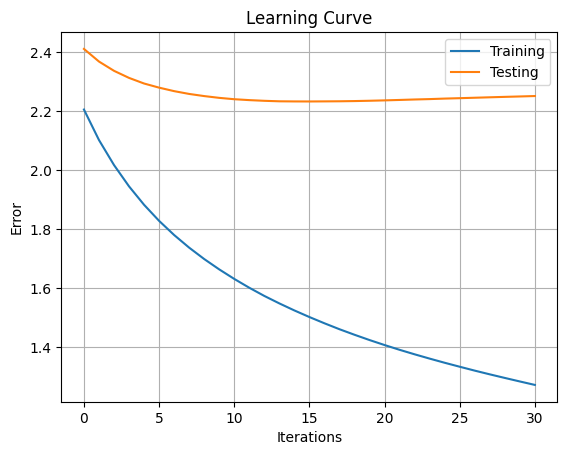

In [11]:
# Plot the learning curves
train_errors = evals_result['train']['MRRMSE']
val_errors = evals_result['eval']['MRRMSE']
plt.plot(train_errors, label='Training')
plt.plot(val_errors, label='Testing')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.title('Learning Curve')
plt.grid(True)
plt.show()

In [12]:
# Save best model
bst.save_model('/kaggle/working/xgb_model.json')

# Save best hyperparameters
import json
with open('/kaggle/working/xgb_best_params.json', 'w') as f:
    json.dump(best_params, f)